In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,  roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier

In [9]:
pd.set_option('display.max_rows', 400)
pd.set_option('max_colwidth', 120)
pd.set_option('display.max_columns', None)

In [10]:
models = {'rf_v1': RandomForestClassifier(random_state=42),
          'rf_v2': RandomForestClassifier(random_state=42),
          'rf_mod_v1': RandomForestClassifier(random_state=42),
          'rf_mod_v1_03': RandomForestClassifier(random_state=42),
          'rf_mod_v2': RandomForestClassifier(random_state=42),
          'xgb_v1': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc'),
          'xgb_v2': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc'),
          'xgb_mod_v1': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc'),
          'xgb_mod_v1_03': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc'),
          'xgb_mod_v2': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc'),
          'dt' : DecisionTreeClassifier(random_state=42)}
data_list = {'rf_v1': dict(),
            'rf_v2': dict(),
            'rf_mod_v1': dict(),
            'rf_mod_v1_03': dict(),
            'rf_mod_v2': dict(),
            'xgb_v1': dict(),
            'xgb_v2': dict(),
            'xgb_mod_v1': dict(),
            'xgb_mod_v1_03': dict(),
            'xgb_mod_v2': dict(),
            'dt' : dict}

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [11]:
class CustomTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# This function takes a dataframe as input and returns a scaled version
def scale_df(input_df):
    ss = StandardScaler()
    feature_names = input_df.columns
    input_df = ss.fit_transform(input_df)
    input_df = pd.DataFrame(input_df, columns=feature_names)
    return input_df

In [12]:
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(part, mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', CustomTransformer(scale_df)),
            (mod, models[mod])
            ])
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(data_list[part]['X_train'], data_list[part]['y_train'])
        print(gs.cv_results_['mean_test_score'])
        print(gs.cv_results_['std_test_score'])
        print(gs.cv_results_['params'])
        pipe = gs.best_estimator_
        
    else:
        pipe.fit(data_list[part]['X_train'], data_list[part]['y_train'])
    # Retrieve metrics
    predictions = pipe.predict(data_list[part]['X_test'])
    tn, fp, fn, tp = confusion_matrix(data_list[part]['y_test'], predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(data_list[part]['X_test'])[:,1]
    y_train_pred_prob = pipe.predict_proba(data_list[part]['X_train'])[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(data_list[part]['y_train'], y_train_pred_prob)
    results['test_auc'] = roc_auc_score(data_list[part]['y_test'], y_test_pred_prob)
    results['precision'] = precision_score(data_list[part]['y_test'], predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(data_list[part]['y_test'], predictions)
    results['f_score'] = f1_score(data_list[part]['y_test'], predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe[1])
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [13]:
def evaluate_model(part, model):
    final_proba = model.predict_proba(data_list[part]['test'])
    final_proba = final_proba[:, 1]
    final_preds = model.predict(data_list[part]['test'])
    print(f'Accuracy:', f'{accuracy_score(data_list[part]["final_actual"], final_preds):.3f}')
    print(f'Precision:', f'{precision_score(data_list[part]["final_actual"], final_preds):.3f}')
    print(f'Recall:', f'{recall_score(data_list[part]["final_actual"], final_preds):.3f}')
    print(f'ROC-AUC:', f'{roc_auc_score(data_list[part]["final_actual"], final_proba):.3f}')
    tn, fp, fn, tp = confusion_matrix(data_list[part]['final_actual'], final_preds).ravel()
    data_list[part]['tp'] = tp
    data_list[part]['tn'] = tn
    data_list[part]['fp'] = fp
    data_list[part]['fn'] = fn
    data_list[part]['accuracy'] = accuracy_score(data_list[part]['final_actual'], final_preds)
    data_list[part]['precision'] = precision_score(data_list[part]['final_actual'], final_preds)
    data_list[part]['specificity'] = tn / (tn + fp)
    data_list[part]['recall'] = recall_score(data_list[part]['final_actual'], final_preds)
    data_list[part]['f_score'] = f1_score(data_list[part]['final_actual'], final_preds)
    data_list[part]['roc-auc'] = roc_auc_score(data_list[part]['final_actual'], final_proba)

In [14]:
rf_params = {'rf__n_estimators': [100, 200, 300, 400, 500],
             'rf__max_depth': [10, 20, 30, 40, 50, 60],
             'rf__min_samples_leaf': [i for i in range(2, 18)],
            }

xgb_params = { 
              'xgb__learning_rate' : [0.1, 0.2, 0.3], 
              'xgb__max_depth' : [3, 5], 
              'xgb__n_estimators' : [100, 200, 300], 
              'xgb__reg_alpha' : [0.1, 1.0, 1.8, 2.0], 
              'xgb__reg_lambda' : [0.1, 1.0, 2.0, 2.4, 3.0], 
              'xgb__gamma' : [1.0, 2.0, 2.5, 3.0], 
            }

# Random Forest Model


- Unmodified Version1<br/>
Choose the first 40 feature with the higher correlation with is_popular

In [15]:
train = pd.read_pickle('./feature/feat_v1.pkl')
part = 'rf_v1'
X = train.drop(columns=['is_popular','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']


data_list[part]['X_train'], data_list[part]['X_test'], data_list[part]['y_train'], data_list[part]['y_test'] = \
        train_test_split(X, y, test_size=0.3, random_state=42)
feature_names = data_list[part]['X_train'].columns

rf_v1 = run_model(part, 'rf_v1')
rf_v1_param = { 
              'rf_v1__n_estimators': [300],
             'rf_v1__max_depth': [20],
             'rf_v1__min_samples_leaf': [2],
            }
rf_gs_v1 = run_model(part, 'rf_v1', mod_params=rf_v1_param, grid_search=True)
data_list[part]['test'] = pd.read_pickle('./feature/feat_test_v1.pkl')
data_list[part]['test'] = data_list[part]['test']._get_numeric_data()

data_list[part]['final_actual'] = data_list[part]['test']['is_popular']
data_list[part]['test'] = data_list[part]['test'].drop(columns=['is_popular', 'feature_subsection_name', 'group_by_subsection_name'])
evaluate_model(part, rf_gs_v1)
rf_gs_v1.fit(X, y)
print(' ')
evaluate_model(part, rf_gs_v1)

### METRICS ###


{'model': 'rf_v1',
 'train_auc': 0.9999999648146146,
 'test_auc': 0.8861427964945664,
 'precision': 0.757903324495207,
 'specificity': 0.9088535667664901,
 'recall': 0.6249579549276825,
 'f_score': 0.6850400958613697}

True Negatives: 11836
False Positives: 1187
False Negatives: 2230
True Positives: 3716
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[0.88137304]
[0.00273027]
[{'rf_v1__max_depth': 20, 'rf_v1__min_samples_leaf': 2, 'rf_v1__n_estimators': 300}]
### BEST PARAMS ###


RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=300,
                       random_state=42)

### METRICS ###


{'model': 'rf_v1',
 'train_auc': 0.9945258882383992,
 'test_auc': 0.8893295178891113,
 'precision': 0.7667644593461861,
 'specificity': 0.9145358212393457,
 'recall': 0.6153716784392869,
 'f_score': 0.6827766374323568}

True Negatives: 11910
False Positives: 1113
False Negatives: 2287
True Positives: 3659
Accuracy: 0.806
Precision: 0.761
Recall: 0.566
ROC-AUC: 0.879
 
Accuracy: 0.810
Precision: 0.772
Recall: 0.568
ROC-AUC: 0.882


- feature importance<br/>

<Axes: >

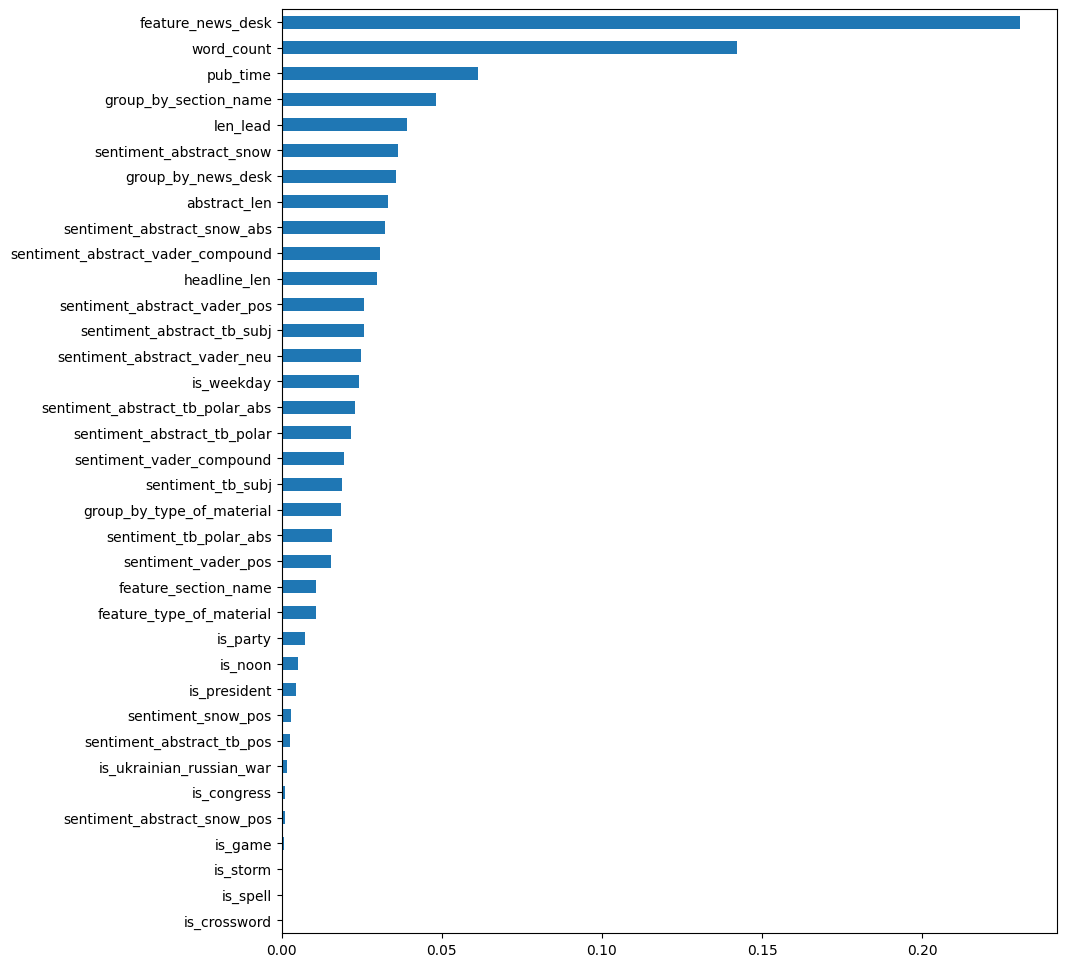

In [16]:
plt.figure(figsize=(10,12))
rf_feature_imp = pd.Series(rf_gs_v1[1][1].feature_importances_, index=X.columns).sort_values(ascending=False)
rf_feature_imp.sort_values().plot(kind = 'barh')

- Unmodified Version2<br/>
The dataset has 30% is_popular data, as same as the modified dataset.

In [17]:
train = pd.read_pickle('./feature/feat_v2.pkl')
part = 'rf_v2'
X = train.drop(columns=['is_popular'])
y = train['is_popular']


data_list[part]['X_train'], data_list[part]['X_test'], data_list[part]['y_train'], data_list[part]['y_test'] = \
        train_test_split(X, y, test_size=0.3, random_state=42)
feature_names = data_list[part]['X_train'].columns

rf_v2 = run_model(part, 'rf_v2')
rf_v2_param = { 
              'rf_v2__n_estimators': [300],
             'rf_v2__max_depth': [25],
             'rf_v2__min_samples_leaf': [2],
            }
rf_gs_v2 = run_model(part, 'rf_v2', mod_params=rf_v2_param, grid_search=True)
data_list[part]['test'] = pd.read_pickle('./feature/feat_test_v2.pkl')
data_list[part]['test'] = data_list[part]['test']._get_numeric_data()

data_list[part]['final_actual'] = data_list[part]['test']['is_popular']
data_list[part]['test'] = data_list[part]['test'].drop(columns=['is_popular'])
evaluate_model(part, rf_gs_v2)
rf_gs_v2.fit(X, y)
print(' ')
evaluate_model(part, rf_gs_v2)

### METRICS ###


{'model': 'rf_v2',
 'train_auc': 1.0,
 'test_auc': 0.86937673076168,
 'precision': 0.7567805953693495,
 'specificity': 0.9150296587319929,
 'recall': 0.5731462925851704,
 'f_score': 0.6522854699230257}

True Negatives: 11878
False Positives: 1103
False Negatives: 2556
True Positives: 3432
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[0.87214]
[0.00044264]
[{'rf_v2__max_depth': 25, 'rf_v2__min_samples_leaf': 2, 'rf_v2__n_estimators': 300}]
### BEST PARAMS ###


RandomForestClassifier(max_depth=25, min_samples_leaf=2, n_estimators=300,
                       random_state=42)

### METRICS ###


{'model': 'rf_v2',
 'train_auc': 0.9992118437351512,
 'test_auc': 0.8714927801318169,
 'precision': 0.7645997745208568,
 'specificity': 0.9195747631153224,
 'recall': 0.5662992651970608,
 'f_score': 0.6506763887556366}

True Negatives: 11937
False Positives: 1044
False Negatives: 2597
True Positives: 3391
Accuracy: 0.796
Precision: 0.754
Recall: 0.530
ROC-AUC: 0.864
 
Accuracy: 0.797
Precision: 0.757
Recall: 0.532
ROC-AUC: 0.866


<Axes: >

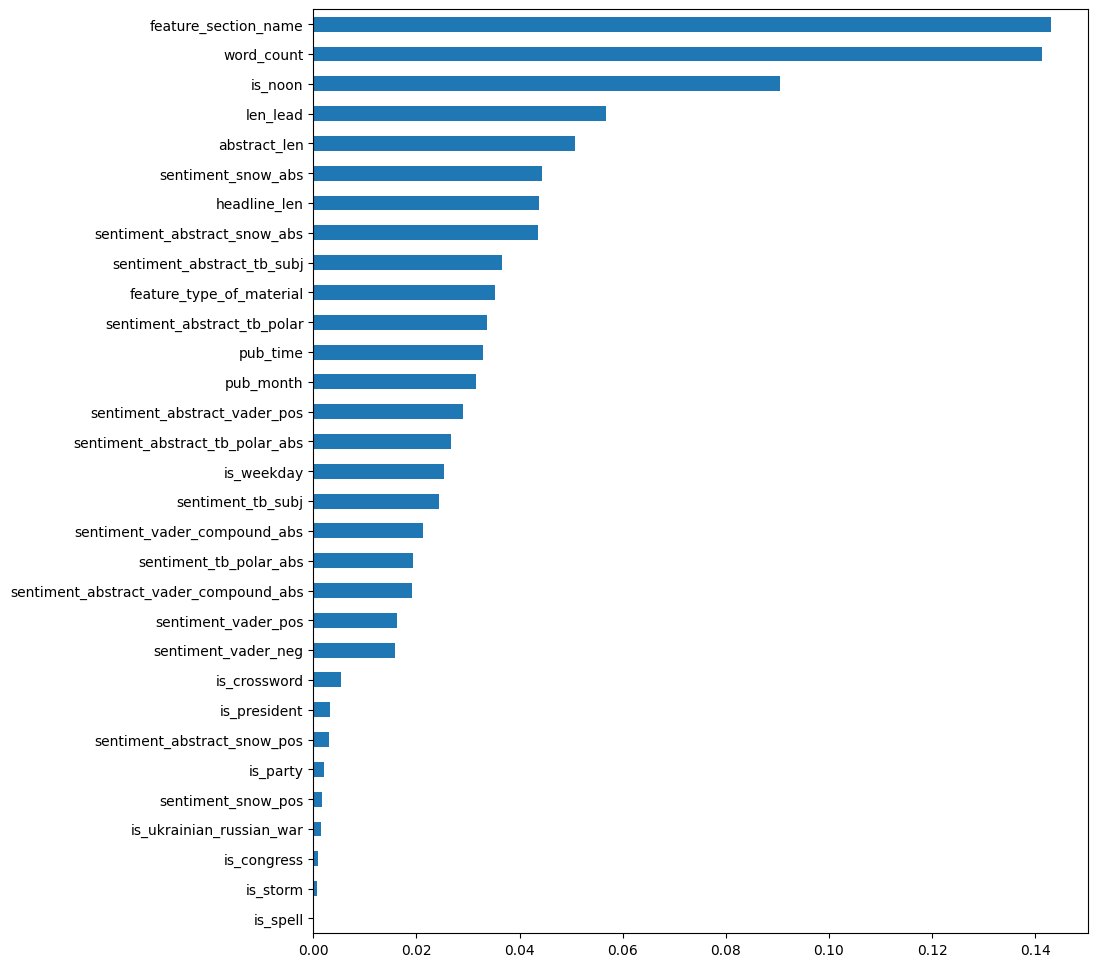

In [18]:
plt.figure(figsize=(10,12))
rf_feature_imp = pd.Series(rf_gs_v2[1][1].feature_importances_, index=X.columns).sort_values(ascending=False)
rf_feature_imp.sort_values().plot(kind = 'barh')

- Modified Version1<br/>
Choose the first 40 feature with the higher correlation with is_popular

In [19]:
train = pd.read_pickle('./feature/feat_modified_v1.pkl')
part = 'rf_mod_v1'
X = train.drop(columns=['is_popular','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']


data_list[part]['X_train'], data_list[part]['X_test'], data_list[part]['y_train'], data_list[part]['y_test'] = \
        train_test_split(X, y, test_size=0.3, random_state=42)
feature_names = data_list[part]['X_train'].columns

rf_mod_v1 = run_model(part, 'rf_mod_v1')
rf_mod_v1_param = { 
              'rf_mod_v1__n_estimators': [300],
             'rf_mod_v1__max_depth': [15],
             'rf_mod_v1__min_samples_leaf': [7],
            }
rf_gs_mod_v1 = run_model(part, 'rf_mod_v1', mod_params=rf_mod_v1_param, grid_search=True)
data_list[part]['test'] = pd.read_pickle('./feature/feat_test_modified_v1.pkl')
data_list[part]['test'] = data_list[part]['test']._get_numeric_data()

data_list[part]['final_actual'] = data_list[part]['test']['is_popular']
data_list[part]['test'] = data_list[part]['test'].drop(columns=['is_popular', 'feature_subsection_name', 'group_by_subsection_name'])
evaluate_model(part, rf_gs_mod_v1)
rf_gs_mod_v1.fit(X, y)
print(' ')
evaluate_model(part, rf_gs_mod_v1)

### METRICS ###


{'model': 'rf_mod_v1',
 'train_auc': 0.999987729009876,
 'test_auc': 0.8464428625422457,
 'precision': 0.7799077032303869,
 'specificity': 0.7926421404682275,
 'recall': 0.7217477003942181,
 'f_score': 0.7497014161405904}

True Negatives: 2370
False Positives: 620
False Negatives: 847
True Positives: 2197
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[0.84857844]
[0.00252296]
[{'rf_mod_v1__max_depth': 15, 'rf_mod_v1__min_samples_leaf': 7, 'rf_mod_v1__n_estimators': 300}]
### BEST PARAMS ###


RandomForestClassifier(max_depth=15, min_samples_leaf=7, n_estimators=300,
                       random_state=42)

### METRICS ###


{'model': 'rf_mod_v1',
 'train_auc': 0.9389620365032085,
 'test_auc': 0.8477250603193298,
 'precision': 0.7939238653001464,
 'specificity': 0.8117056856187291,
 'recall': 0.7125492772667543,
 'f_score': 0.7510387811634348}

True Negatives: 2427
False Positives: 563
False Negatives: 875
True Positives: 2169
Accuracy: 0.763
Precision: 0.780
Recall: 0.732
ROC-AUC: 0.852
 
Accuracy: 0.765
Precision: 0.777
Recall: 0.743
ROC-AUC: 0.853


<Axes: >

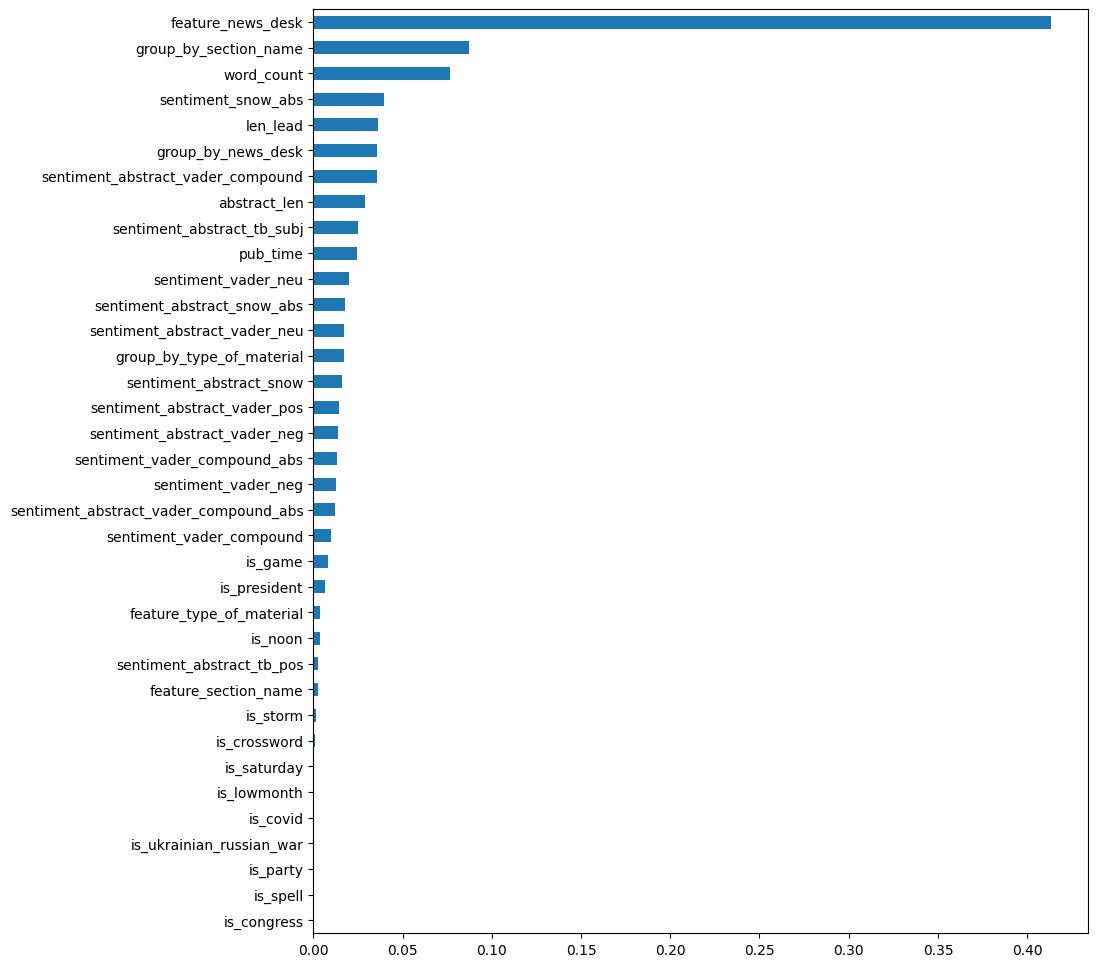

In [20]:
plt.figure(figsize=(10,12))
rf_feature_imp = pd.Series(rf_gs_mod_v1[1][1].feature_importances_, index=X.columns).sort_values(ascending=False)
rf_feature_imp.sort_values().plot(kind = 'barh')

- Modified Version1.03<br/>

In [21]:
train = pd.read_pickle('./feature/feat_modified_v1_0.3.pkl')
part = 'rf_mod_v1_03'
X = train.drop(columns=['is_popular','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']


data_list[part]['X_train'], data_list[part]['X_test'], data_list[part]['y_train'], data_list[part]['y_test'] = \
        train_test_split(X, y, test_size=0.3, random_state=42)
feature_names = data_list[part]['X_train'].columns

rf_mod_v1_03 = run_model(part, 'rf_mod_v1_03')
rf_mod_v1_03_param = { 
              'rf_mod_v1_03__n_estimators': [300],
             'rf_mod_v1_03__max_depth': [20],
             'rf_mod_v1_03__min_samples_leaf': [6],
            }
rf_gs_mod_v1_03 = run_model(part, 'rf_mod_v1_03', mod_params=rf_mod_v1_03_param, grid_search=True)
data_list[part]['test'] = pd.read_pickle('./feature/feat_test_modified_v1_0.3.pkl')
data_list[part]['test'] = data_list[part]['test']._get_numeric_data()

data_list[part]['final_actual'] = data_list[part]['test']['is_popular']
data_list[part]['test'] = data_list[part]['test'].drop(columns=['is_popular', 'feature_subsection_name', 'group_by_subsection_name'])
evaluate_model(part, rf_gs_mod_v1_03)
rf_gs_mod_v1_03.fit(X, y)
print(' ')
evaluate_model(part, rf_gs_mod_v1_03)

### METRICS ###


{'model': 'rf_mod_v1_03',
 'train_auc': 0.999946087670131,
 'test_auc': 0.8419421476926257,
 'precision': 0.7475434618291761,
 'specificity': 0.9201720841300192,
 'recall': 0.5345945945945946,
 'f_score': 0.6233848093287109}

True Negatives: 3850
False Positives: 334
False Negatives: 861
True Positives: 989
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[0.86010346]
[0.00499947]
[{'rf_mod_v1_03__max_depth': 20, 'rf_mod_v1_03__min_samples_leaf': 6, 'rf_mod_v1_03__n_estimators': 300}]
### BEST PARAMS ###


RandomForestClassifier(max_depth=20, min_samples_leaf=6, n_estimators=300,
                       random_state=42)

### METRICS ###


{'model': 'rf_mod_v1_03',
 'train_auc': 0.9666643697103863,
 'test_auc': 0.8477793783267015,
 'precision': 0.7621247113163973,
 'specificity': 0.9261472275334608,
 'recall': 0.5351351351351351,
 'f_score': 0.6287710384248968}

True Negatives: 3875
False Positives: 309
False Negatives: 860
True Positives: 990
Accuracy: 0.810
Precision: 0.744
Recall: 0.541
ROC-AUC: 0.844
 
Accuracy: 0.810
Precision: 0.734
Recall: 0.555
ROC-AUC: 0.845


<Axes: >

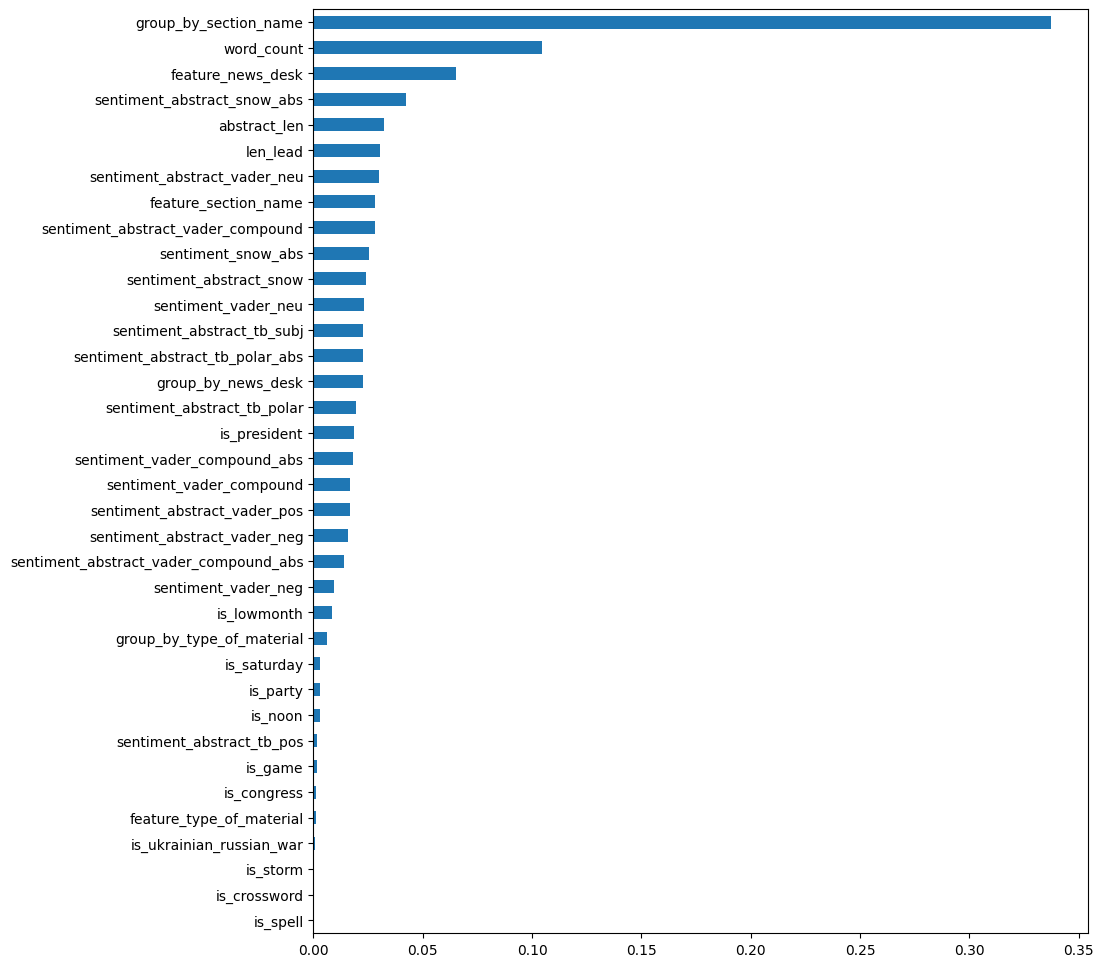

In [22]:
plt.figure(figsize=(10,12))
rf_feature_imp = pd.Series(rf_gs_mod_v1_03[1][1].feature_importances_, index=X.columns).sort_values(ascending=False)
rf_feature_imp.sort_values().plot(kind = 'barh')

- Modified Version2<br/>

In [23]:
train = pd.read_pickle('./feature/feat_modified_v2.pkl')
part = 'rf_mod_v2'
X = train.drop(columns=['is_popular'])
y = train['is_popular']


data_list[part]['X_train'], data_list[part]['X_test'], data_list[part]['y_train'], data_list[part]['y_test'] = \
        train_test_split(X, y, test_size=0.3, random_state=42)
feature_names = data_list[part]['X_train'].columns

rf_mod_v2 = run_model(part, 'rf_mod_v2')
rf_mod_v2_param = { 
              'rf_mod_v2__n_estimators': [300],
             'rf_mod_v2__max_depth': [15],
             'rf_mod_v2__min_samples_leaf': [1],
            }
rf_gs_mod_v2 = run_model(part, 'rf_mod_v2', mod_params=rf_mod_v2_param, grid_search=True)
data_list[part]['test'] = pd.read_pickle('./feature/feat_test_modified_v2.pkl')
data_list[part]['test'] = data_list[part]['test']._get_numeric_data()

data_list[part]['final_actual'] = data_list[part]['test']['is_popular']
data_list[part]['test'] = data_list[part]['test'].drop(columns=['is_popular'])
evaluate_model(part, rf_gs_mod_v2)
rf_gs_mod_v2.fit(X, y)
print(' ')
evaluate_model(part, rf_gs_mod_v2)

### METRICS ###


{'model': 'rf_mod_v2',
 'train_auc': 0.9999998284473005,
 'test_auc': 0.8429653496469678,
 'precision': 0.7760589318600368,
 'specificity': 0.8025974025974026,
 'recall': 0.7132701421800948,
 'f_score': 0.743340977244664}

True Negatives: 2472
False Positives: 608
False Negatives: 847
True Positives: 2107
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[0.84860614]
[0.00494201]
[{'rf_mod_v2__max_depth': 15, 'rf_mod_v2__min_samples_leaf': 1, 'rf_mod_v2__n_estimators': 300}]
### BEST PARAMS ###


RandomForestClassifier(max_depth=15, n_estimators=300, random_state=42)

### METRICS ###


{'model': 'rf_mod_v2',
 'train_auc': 0.982928881698207,
 'test_auc': 0.8465188078678262,
 'precision': 0.7809094325441563,
 'specificity': 0.8107142857142857,
 'recall': 0.7034529451591063,
 'f_score': 0.7401602849510239}

True Negatives: 2497
False Positives: 583
False Negatives: 876
True Positives: 2078
Accuracy: 0.755
Precision: 0.785
Recall: 0.701
ROC-AUC: 0.846
 
Accuracy: 0.759
Precision: 0.783
Recall: 0.715
ROC-AUC: 0.848


<Axes: >

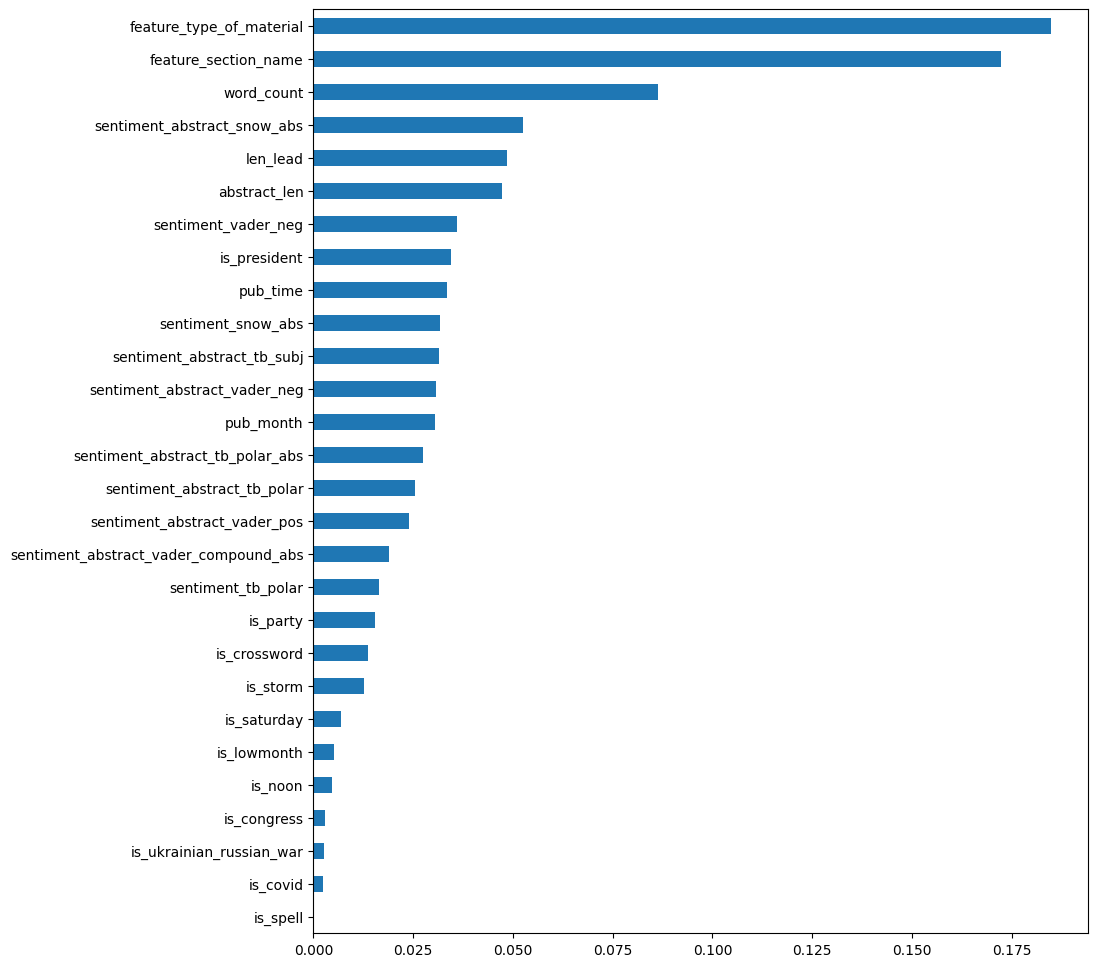

In [24]:
plt.figure(figsize=(10,12))
rf_feature_imp = pd.Series(rf_gs_mod_v2[1][1].feature_importances_, index=X.columns).sort_values(ascending=False)
rf_feature_imp.sort_values().plot(kind = 'barh')

# XGBoost Model

- Unmodified Version1

In [25]:
train = pd.read_pickle('./feature/feat_v1.pkl')
part = 'xgb_v1'
X = train.drop(columns=['is_popular','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']


data_list[part]['X_train'], data_list[part]['X_test'], data_list[part]['y_train'], data_list[part]['y_test'] = \
    train_test_split(X, y, test_size=0.3, random_state=42)

xgb_v1 = run_model(part, 'xgb_v1')
xgb_v1_param = { 
              'xgb_v1__learning_rate' : [0.1], 
              'xgb_v1__max_depth' : [5],
              'xgb_v1__n_estimators' : [300], 
              'xgb_v1__reg_alpha' : [1.0], 
              'xgb_v1__reg_lambda' : [1.0], 
              'xgb_v1__gamma' : [2.5],
            }
xgb_gs_v1 = run_model(part, 'xgb_v1', mod_params=xgb_v1_param, grid_search=True)
data_list[part]['test'] = pd.read_pickle('./feature/feat_test_v1.pkl')
data_list[part]['test'] = data_list[part]['test']._get_numeric_data()

data_list[part]['final_actual'] = data_list[part]['test']['is_popular']
data_list[part]['test'] = data_list[part]['test'].drop(columns=['is_popular', 'feature_subsection_name', 'group_by_subsection_name'])

evaluate_model(part, xgb_gs_v1)
xgb_gs_v1.fit(X, y)
print(' ')
evaluate_model(part, xgb_gs_v1)

### METRICS ###


{'model': 'xgb_v1',
 'train_auc': 0.9445394233524427,
 'test_auc': 0.8819288813429236,
 'precision': 0.7268457636671051,
 'specificity': 0.8883513783306458,
 'recall': 0.6506895391860074,
 'f_score': 0.6866625255124679}

True Negatives: 11569
False Positives: 1454
False Negatives: 2077
True Positives: 3869
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[0.87951052]
[0.00196463]
[{'xgb_v1__gamma': 2.5, 'xgb_v1__learning_rate': 0.1, 'xgb_v1__max_depth': 5, 'xgb_v1__n_estimators': 300, 'xgb_v1__reg_alpha': 1.0, 'xgb_v1__reg_lambda': 1.0}]
### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb_v1',
 'train_auc': 0.9225078726361484,
 'test_auc': 0.8847406677502627,
 'precision': 0.7348139711465452,
 'specificity': 0.8927282500191968,
 'recall': 0.6510258997645476,
 'f_score': 0.6903870162297129}

True Negatives: 11626
False Positives: 1397
False Negatives: 2075
True Positives: 3871
Accuracy: 0.808
Precision: 0.738
Recall: 0.610
ROC-AUC: 0.880
 
Accuracy: 0.814
Precision: 0.754
Recall: 0.612
ROC-AUC: 0.882


In [26]:
scores_dict = xgb_gs_v1.steps[1][1]._Booster.get_score(importance_type='gain')

In [27]:
total_cover = pd.DataFrame(xgb_gs_v1.steps[1][1]._Booster.get_score(importance_type='total_cover'), index=[0]) \
            .T.reset_index()
total_cover.columns = ['feature', 'total cover']
total_cover = total_cover.sort_values(by='total cover', ascending=False)

In [28]:
total_gain = pd.DataFrame(xgb_gs_v1.steps[1][1]._Booster.get_score(importance_type='total_gain'), index=[0]) \
            .T.reset_index()
total_gain.columns = ['feature', 'total gain']
total_gain = total_gain.sort_values(by='total gain', ascending=False)

In [29]:
gain_df = pd.DataFrame(xgb_gs_v1.steps[1][1]._Booster.get_score(importance_type='gain'), index=[0]) \
            .T.reset_index()
gain_df.columns = ['feature', 'gain']
gain_df = gain_df.sort_values(by='gain', ascending=False)

In [30]:
weight_df = pd.DataFrame(xgb_gs_v1.steps[1][1]._Booster.get_score(importance_type='weight'), index=[0]) \
            .T.reset_index()
weight_df.columns = ['feature', 'weight']
weight_df = weight_df.sort_values(by='weight', ascending=False)

In [31]:
cover_df = pd.DataFrame(xgb_gs_v1.steps[1][1]._Booster.get_score(importance_type='cover'), index=[0]) \
            .T.reset_index()
cover_df.columns = ['feature', 'cover']
cover_df = cover_df.sort_values(by='cover', ascending=False)

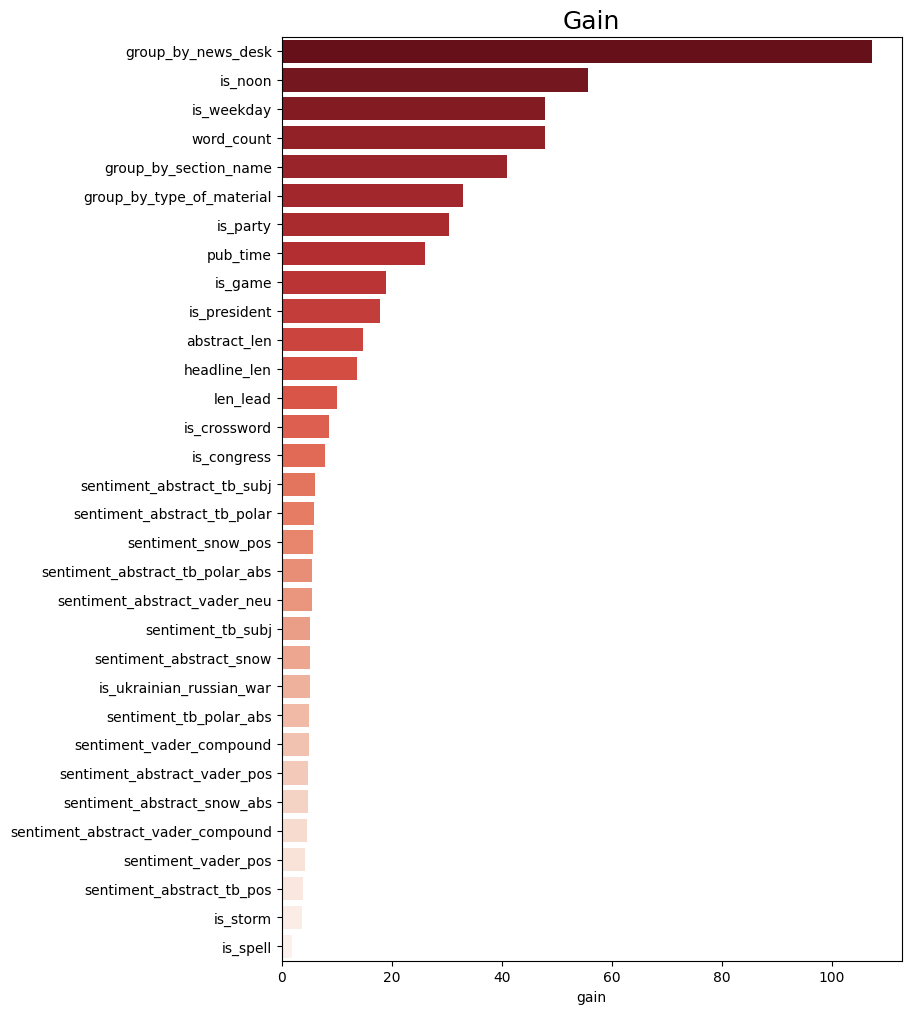

In [32]:
plt.figure(figsize=(8,12))
sns.barplot(data=gain_df, y='feature', x='gain', orient='h', palette='Reds_r')
plt.ylabel('');
plt.title('Gain', fontsize=18);

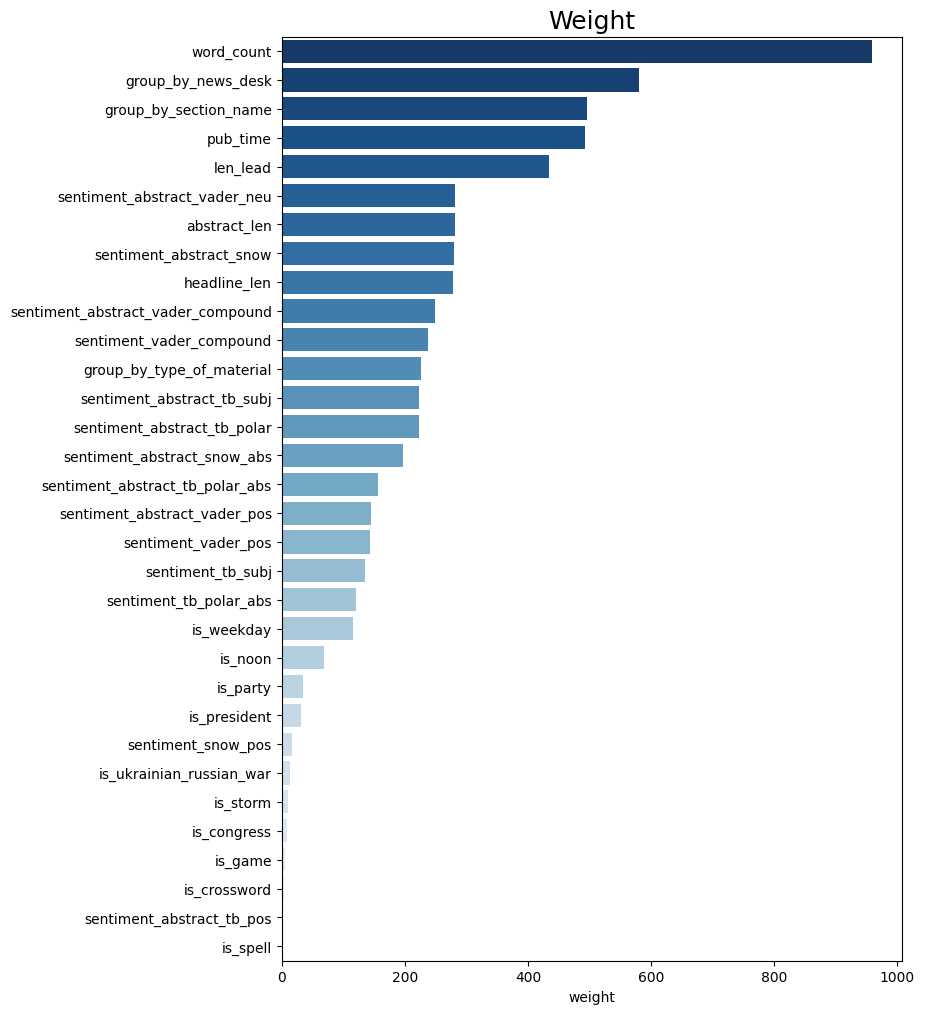

In [33]:
plt.figure(figsize=(8,12))
sns.barplot(data=weight_df, y='feature', x='weight', orient='h', palette='Blues_r')
plt.ylabel('');
plt.title('Weight', fontsize=18);

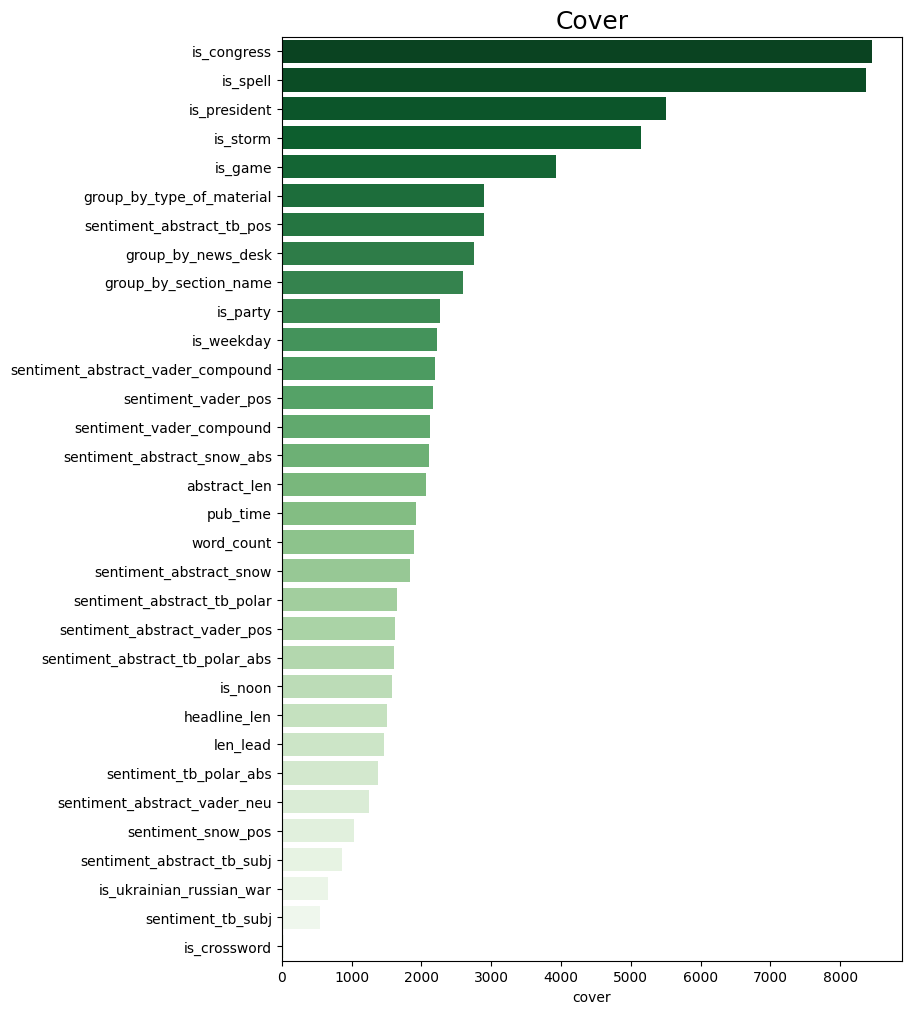

In [34]:
plt.figure(figsize=(8,12))
sns.barplot(data=cover_df, y='feature', x='cover', orient='h', palette='Greens_r')
plt.ylabel('');
plt.title('Cover', fontsize=18);

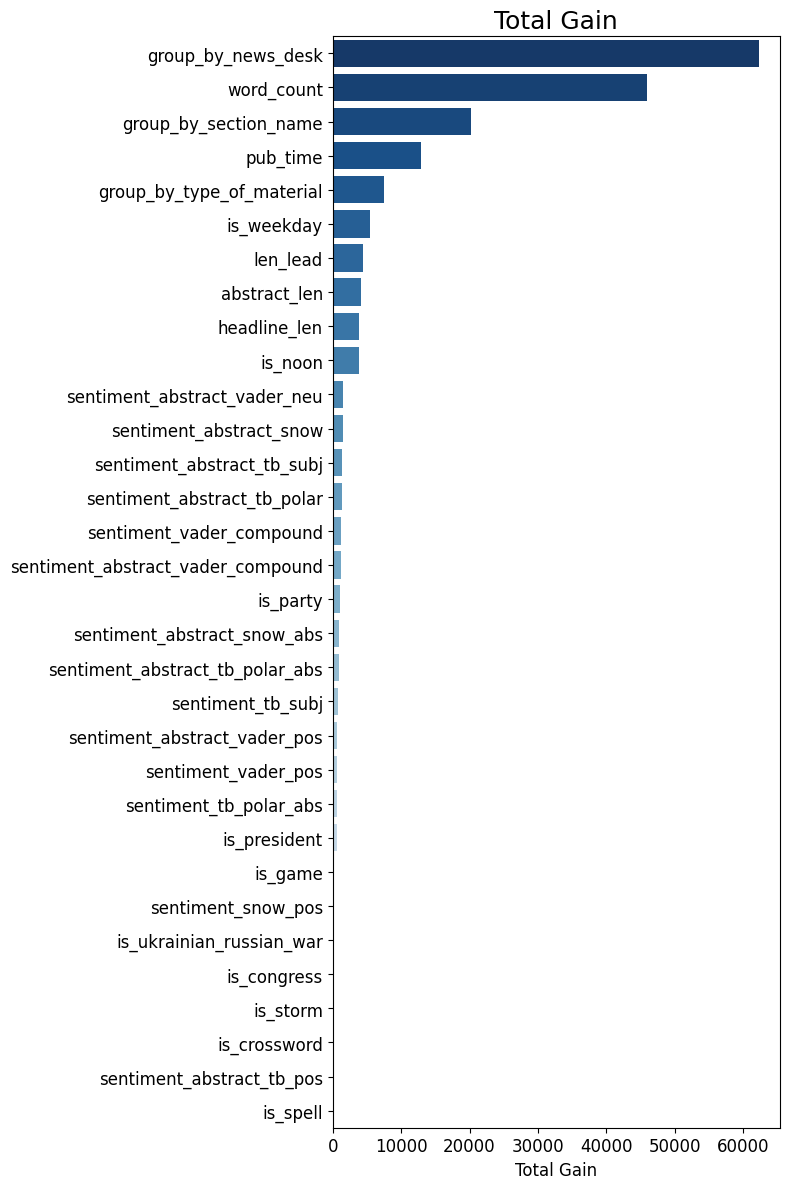

In [35]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_gain, y='feature', x='total gain', orient='h', palette='Blues_r')
plt.ylabel('');
plt.xlabel('Total Gain', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Gain', fontsize=18)
plt.tight_layout()
plt.savefig(fname='total_gain', dpi=180)

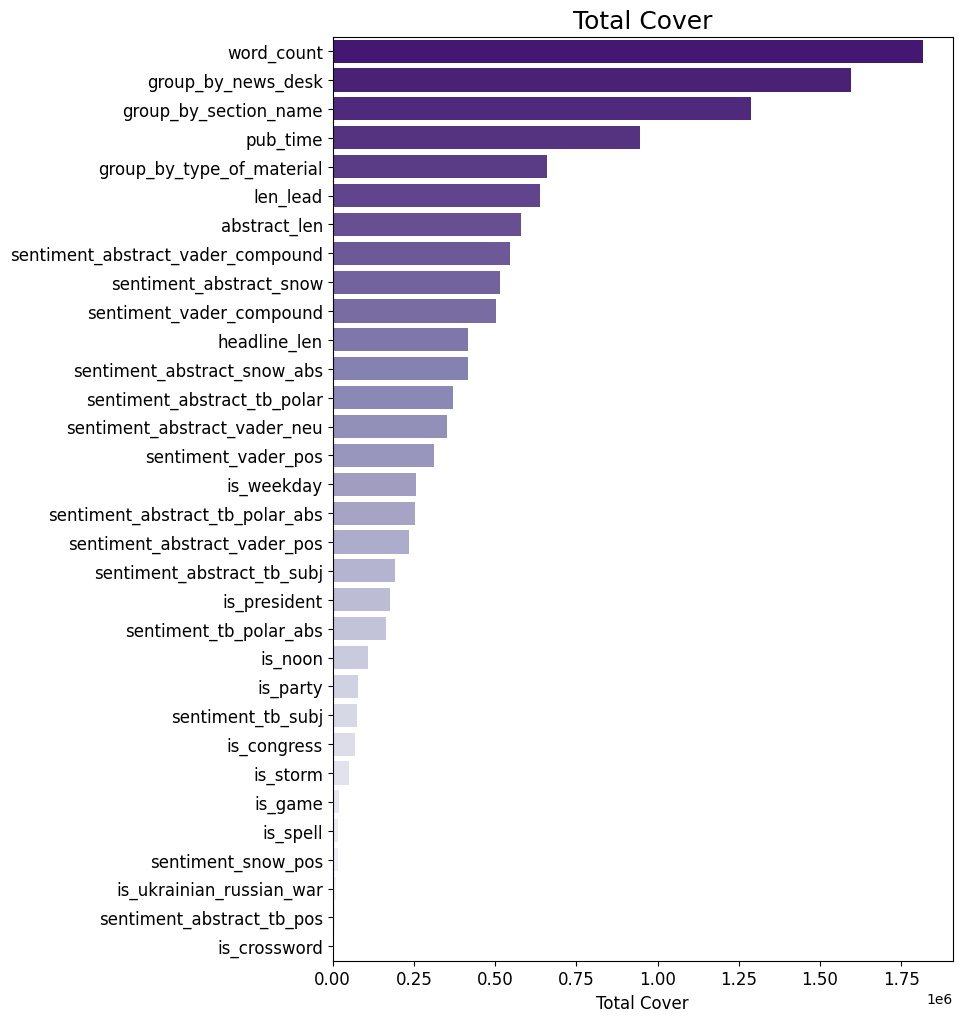

In [36]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_cover, y='feature', x='total cover', orient='h', palette='Purples_r')
plt.ylabel('');
plt.xlabel('Total Cover', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Cover', fontsize=18);

- Unmodified Version2

In [37]:
train = pd.read_pickle('./feature/feat_v2.pkl')
part = 'xgb_v2'
X = train.drop(columns=['is_popular'])
y = train['is_popular']


data_list[part]['X_train'], data_list[part]['X_test'], data_list[part]['y_train'], data_list[part]['y_test'] = \
    train_test_split(X, y, test_size=0.3, random_state=42)

xgb_v2 = run_model(part, 'xgb_v2')
xgb_v2_param = { 
              'xgb_v2__learning_rate' : [0.1], 
              'xgb_v2__max_depth' : [5],
              'xgb_v2__n_estimators' : [300], 
              'xgb_v2__reg_alpha' : [1.0], 
              'xgb_v2__reg_lambda' : [3.0], 
              'xgb_v2__gamma' : [2.0],
            }
xgb_gs_v2 = run_model(part, 'xgb_v2', mod_params=xgb_v2_param, grid_search=True)
data_list[part]['test'] = pd.read_pickle('./feature/feat_test_v2.pkl')
data_list[part]['test'] = data_list[part]['test']._get_numeric_data()

data_list[part]['final_actual'] = data_list[part]['test']['is_popular']
data_list[part]['test'] = data_list[part]['test'].drop(columns=['is_popular'])

evaluate_model(part, xgb_gs_v2)
xgb_gs_v2.fit(X, y)
print(' ')
evaluate_model(part, xgb_gs_v2)

### METRICS ###


{'model': 'xgb_v2',
 'train_auc': 0.9389483633869015,
 'test_auc': 0.8670054653641308,
 'precision': 0.7253210272873194,
 'specificity': 0.8945381711732532,
 'recall': 0.6037074148296593,
 'f_score': 0.6589500546846518}

True Negatives: 11612
False Positives: 1369
False Negatives: 2373
True Positives: 3615
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[0.87101484]
[0.00066675]
[{'xgb_v2__gamma': 2.0, 'xgb_v2__learning_rate': 0.1, 'xgb_v2__max_depth': 5, 'xgb_v2__n_estimators': 300, 'xgb_v2__reg_alpha': 1.0, 'xgb_v2__reg_lambda': 3.0}]
### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb_v2',
 'train_auc': 0.911770113551799,
 'test_auc': 0.8700543950546498,
 'precision': 0.7370672097759674,
 'specificity': 0.9005469532393499,
 'recall': 0.60437541750167,
 'f_score': 0.6641585612038906}

True Negatives: 11690
False Positives: 1291
False Negatives: 2369
True Positives: 3619
Accuracy: 0.796
Precision: 0.722
Recall: 0.579
ROC-AUC: 0.867
 
Accuracy: 0.799
Precision: 0.732
Recall: 0.578
ROC-AUC: 0.869


In [38]:
scores_dict = xgb_gs_v2.steps[1][1]._Booster.get_score(importance_type='gain')
total_cover = pd.DataFrame(xgb_gs_v2.steps[1][1]._Booster.get_score(importance_type='total_cover'), index=[0]) \
            .T.reset_index()
total_cover.columns = ['feature', 'total cover']
total_cover = total_cover.sort_values(by='total cover', ascending=False)
total_gain = pd.DataFrame(xgb_gs_v2.steps[1][1]._Booster.get_score(importance_type='total_gain'), index=[0]) \
            .T.reset_index()
total_gain.columns = ['feature', 'total gain']
total_gain = total_gain.sort_values(by='total gain', ascending=False)
gain_df = pd.DataFrame(xgb_gs_v2.steps[1][1]._Booster.get_score(importance_type='gain'), index=[0]) \
            .T.reset_index()
gain_df.columns = ['feature', 'gain']
gain_df = gain_df.sort_values(by='gain', ascending=False)
weight_df = pd.DataFrame(xgb_gs_v2.steps[1][1]._Booster.get_score(importance_type='weight'), index=[0]) \
            .T.reset_index()
weight_df.columns = ['feature', 'weight']
weight_df = weight_df.sort_values(by='weight', ascending=False)
cover_df = pd.DataFrame(xgb_gs_v2.steps[1][1]._Booster.get_score(importance_type='cover'), index=[0]) \
            .T.reset_index()
cover_df.columns = ['feature', 'cover']
cover_df = cover_df.sort_values(by='cover', ascending=False)

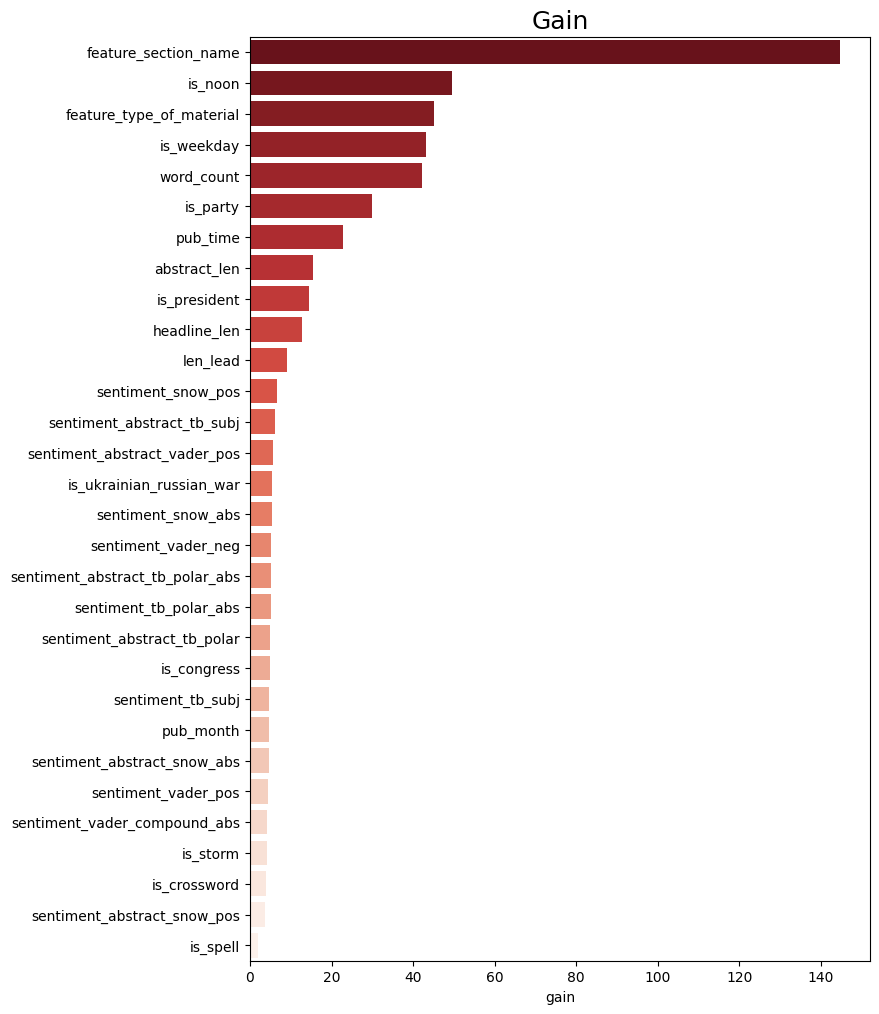

In [39]:
plt.figure(figsize=(8,12))
sns.barplot(data=gain_df, y='feature', x='gain', orient='h', palette='Reds_r')
plt.ylabel('');
plt.title('Gain', fontsize=18);

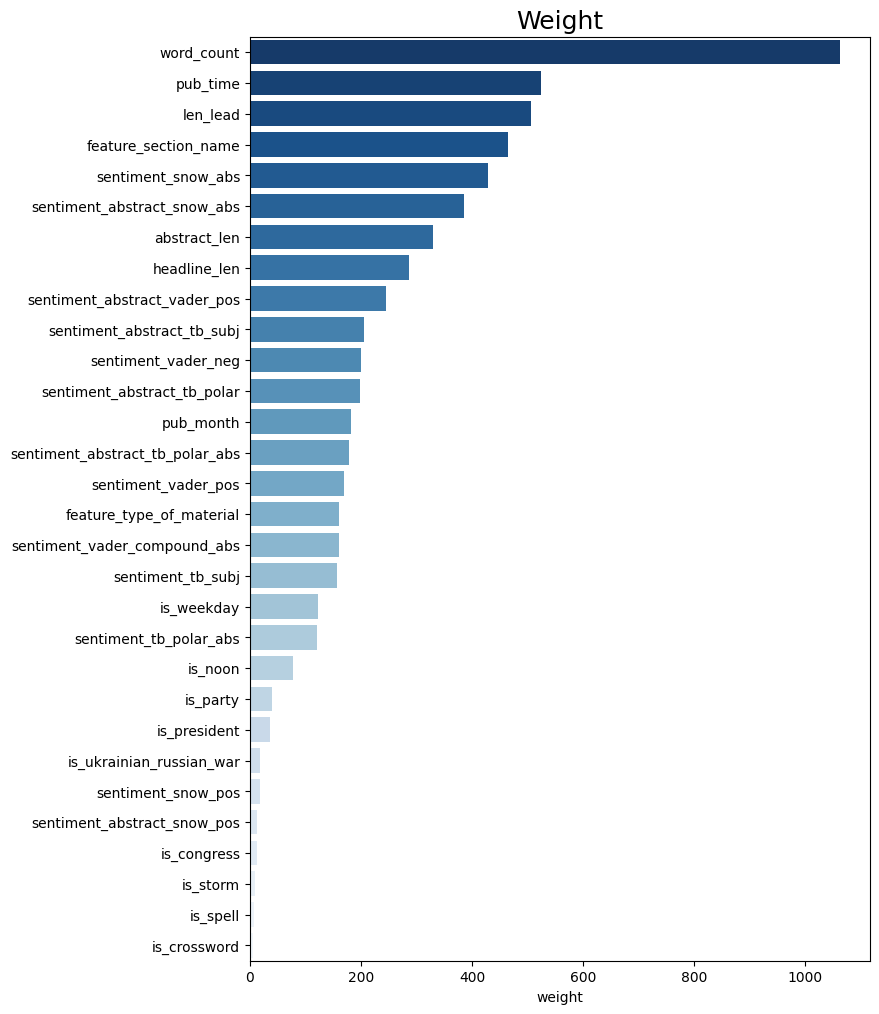

In [40]:
plt.figure(figsize=(8,12))
sns.barplot(data=weight_df, y='feature', x='weight', orient='h', palette='Blues_r')
plt.ylabel('');
plt.title('Weight', fontsize=18);

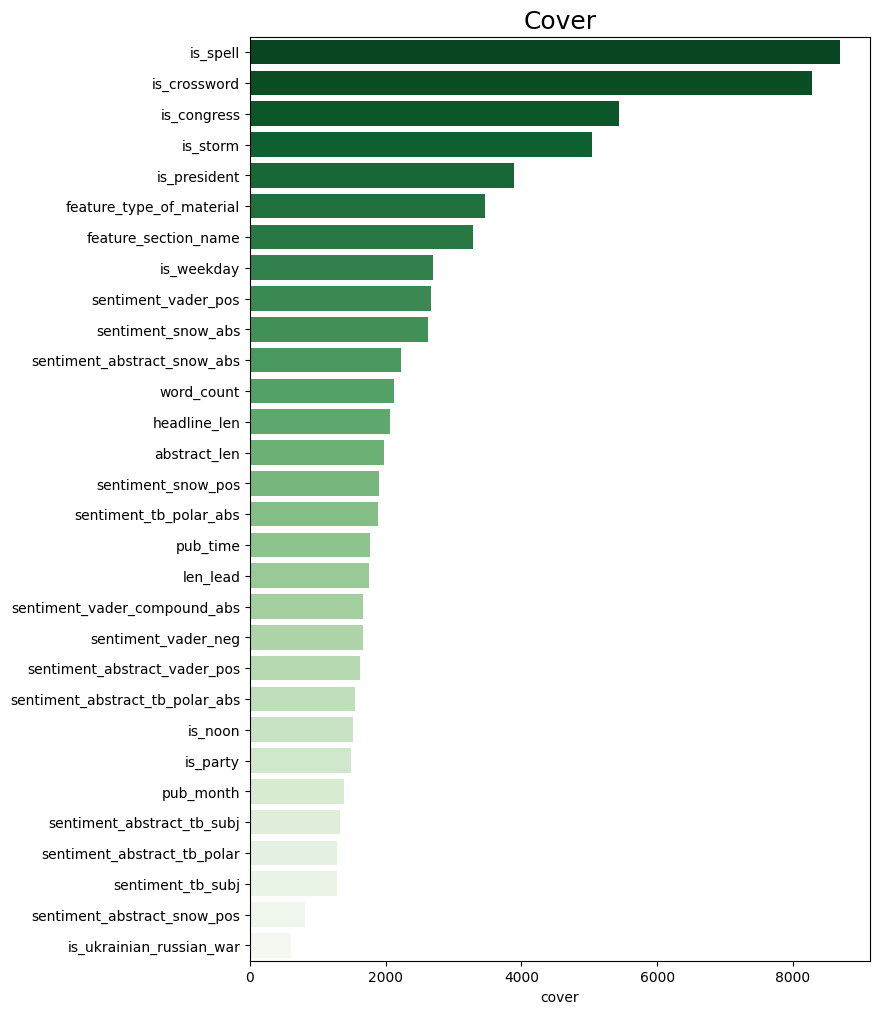

In [41]:
plt.figure(figsize=(8,12))
sns.barplot(data=cover_df, y='feature', x='cover', orient='h', palette='Greens_r')
plt.ylabel('');
plt.title('Cover', fontsize=18);

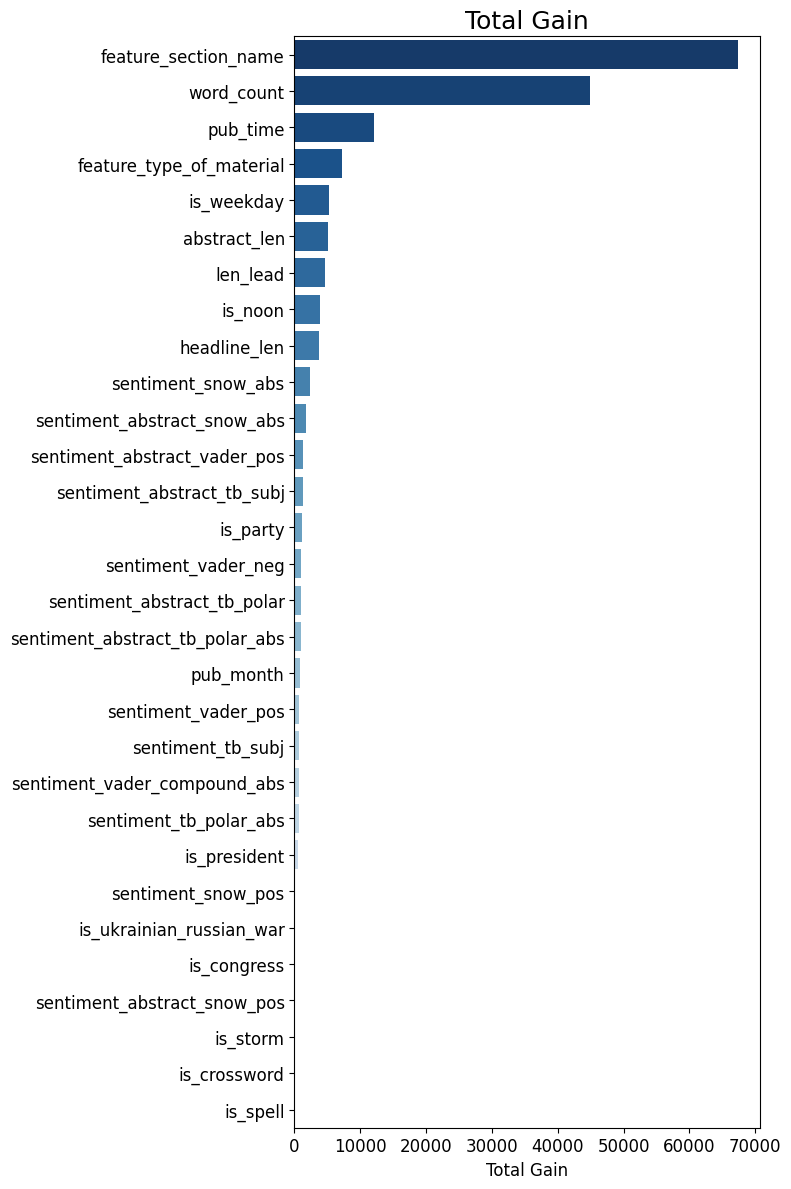

In [42]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_gain, y='feature', x='total gain', orient='h', palette='Blues_r')
plt.ylabel('');
plt.xlabel('Total Gain', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Gain', fontsize=18)
plt.tight_layout()
plt.savefig(fname='total_gain', dpi=180)

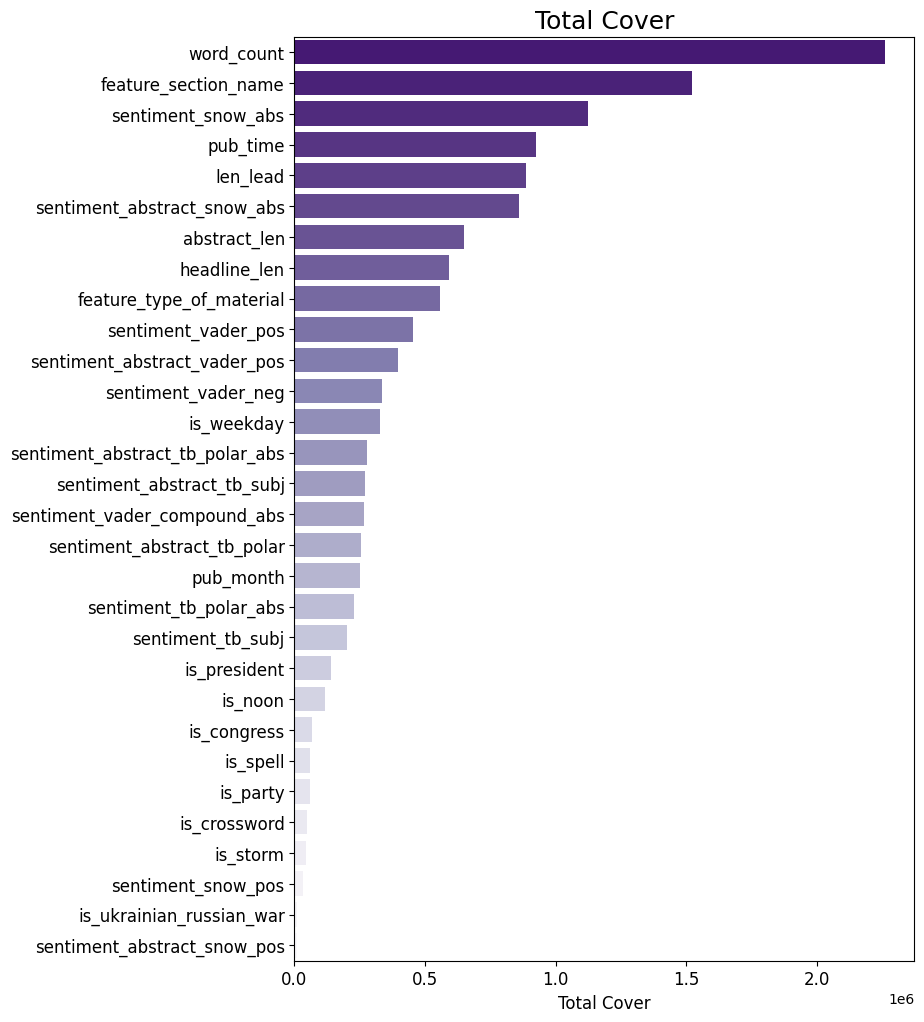

In [43]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_cover, y='feature', x='total cover', orient='h', palette='Purples_r')
plt.ylabel('');
plt.xlabel('Total Cover', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Cover', fontsize=18);

- Modified Version1<br/>
Choose the first 40 feature with the higher correlation with is_popular

In [44]:
train = pd.read_pickle('./feature/feat_modified_v1.pkl')
part = 'xgb_mod_v1'
X = train.drop(columns=['is_popular', 'feature_subsection_name', 'group_by_subsection_name'])
y = train['is_popular']


data_list[part]['X_train'], data_list[part]['X_test'], data_list[part]['y_train'], data_list[part]['y_test'] = \
    train_test_split(X, y, test_size=0.3, random_state=42)

xgb_mod_v1 = run_model(part, 'xgb_mod_v1')
xgb_mod_v1_param = { 
              'xgb_mod_v1__learning_rate' : [0.1], 
              'xgb_mod_v1__max_depth' : [5],
              'xgb_mod_v1__n_estimators' : [100], 
              'xgb_mod_v1__reg_alpha' : [1.8], 
              'xgb_mod_v1__reg_lambda' : [3.0], 
              'xgb_mod_v1__gamma' : [1.0],
            }
xgb_gs_mod_v1 = run_model(part, 'xgb_mod_v1', mod_params=xgb_mod_v1_param, grid_search=True)
data_list[part]['test'] = pd.read_pickle('./feature/feat_test_modified_v1.pkl')
data_list[part]['test'] = data_list[part]['test']._get_numeric_data()

data_list[part]['final_actual'] = data_list[part]['test']['is_popular']
data_list[part]['test'] = data_list[part]['test'].drop(columns=['is_popular', 'feature_subsection_name', 'group_by_subsection_name'])

evaluate_model(part, xgb_gs_mod_v1)
xgb_gs_mod_v1.fit(X, y)
print(' ')
evaluate_model(part, xgb_gs_mod_v1)

### METRICS ###


{'model': 'xgb_mod_v1',
 'train_auc': 0.9757667824862455,
 'test_auc': 0.8373362918005265,
 'precision': 0.7667485092949842,
 'specificity': 0.7775919732441472,
 'recall': 0.7181340341655716,
 'f_score': 0.7416454622561492}

True Negatives: 2325
False Positives: 665
False Negatives: 858
True Positives: 2186
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[0.84612427]
[0.00351768]
[{'xgb_mod_v1__gamma': 1.0, 'xgb_mod_v1__learning_rate': 0.1, 'xgb_mod_v1__max_depth': 5, 'xgb_mod_v1__n_estimators': 100, 'xgb_mod_v1__reg_alpha': 1.8, 'xgb_mod_v1__reg_lambda': 3.0}]
### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb_mod_v1',
 'train_auc': 0.8884656910987327,
 'test_auc': 0.8443048774056316,
 'precision': 0.7876911871813547,
 'specificity': 0.8050167224080268,
 'recall': 0.7105781865965834,
 'f_score': 0.7471502590673575}

True Negatives: 2407
False Positives: 583
False Negatives: 881
True Positives: 2163
Accuracy: 0.763
Precision: 0.777
Recall: 0.737
ROC-AUC: 0.851
 
Accuracy: 0.768
Precision: 0.779
Recall: 0.746
ROC-AUC: 0.853


In [45]:
scores_dict = xgb_gs_mod_v1.steps[1][1]._Booster.get_score(importance_type='gain')
total_cover = pd.DataFrame(xgb_gs_mod_v1.steps[1][1]._Booster.get_score(importance_type='total_cover'), index=[0]) \
            .T.reset_index()
total_cover.columns = ['feature', 'total cover']
total_cover = total_cover.sort_values(by='total cover', ascending=False)
total_gain = pd.DataFrame(xgb_gs_mod_v1.steps[1][1]._Booster.get_score(importance_type='total_gain'), index=[0]) \
            .T.reset_index()
total_gain.columns = ['feature', 'total gain']
total_gain = total_gain.sort_values(by='total gain', ascending=False)
gain_df = pd.DataFrame(xgb_gs_mod_v1.steps[1][1]._Booster.get_score(importance_type='gain'), index=[0]) \
            .T.reset_index()
gain_df.columns = ['feature', 'gain']
gain_df = gain_df.sort_values(by='gain', ascending=False)
weight_df = pd.DataFrame(xgb_gs_mod_v1.steps[1][1]._Booster.get_score(importance_type='weight'), index=[0]) \
            .T.reset_index()
weight_df.columns = ['feature', 'weight']
weight_df = weight_df.sort_values(by='weight', ascending=False)
cover_df = pd.DataFrame(xgb_gs_mod_v1.steps[1][1]._Booster.get_score(importance_type='cover'), index=[0]) \
            .T.reset_index()
cover_df.columns = ['feature', 'cover']
cover_df = cover_df.sort_values(by='cover', ascending=False)

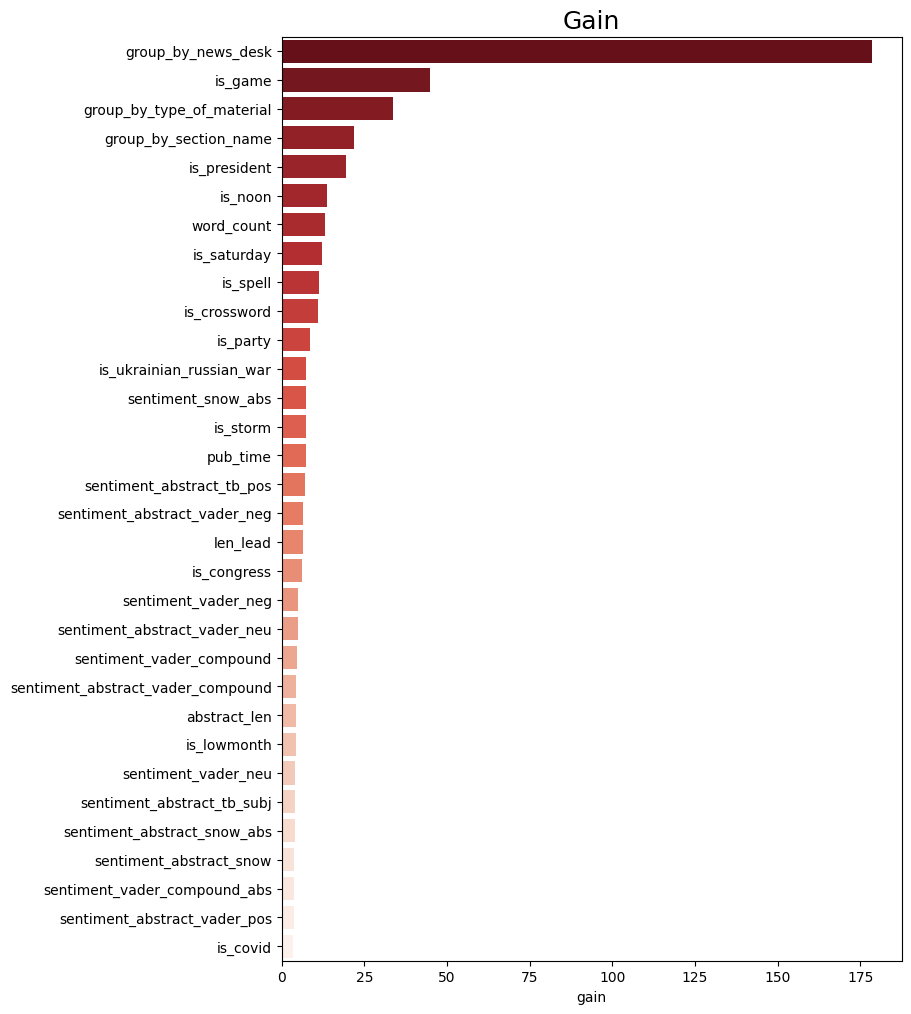

In [46]:
plt.figure(figsize=(8,12))
sns.barplot(data=gain_df, y='feature', x='gain', orient='h', palette='Reds_r')
plt.ylabel('');
plt.title('Gain', fontsize=18);

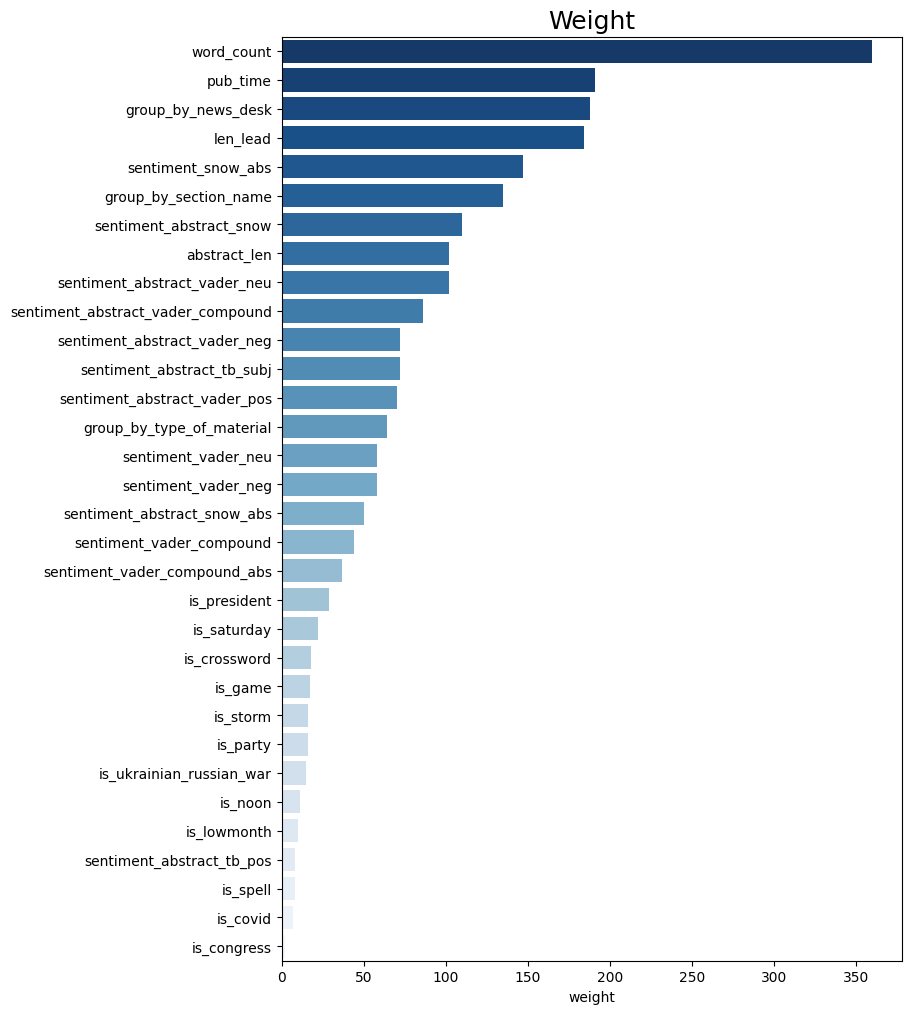

In [47]:
plt.figure(figsize=(8,12))
sns.barplot(data=weight_df, y='feature', x='weight', orient='h', palette='Blues_r')
plt.ylabel('');
plt.title('Weight', fontsize=18);

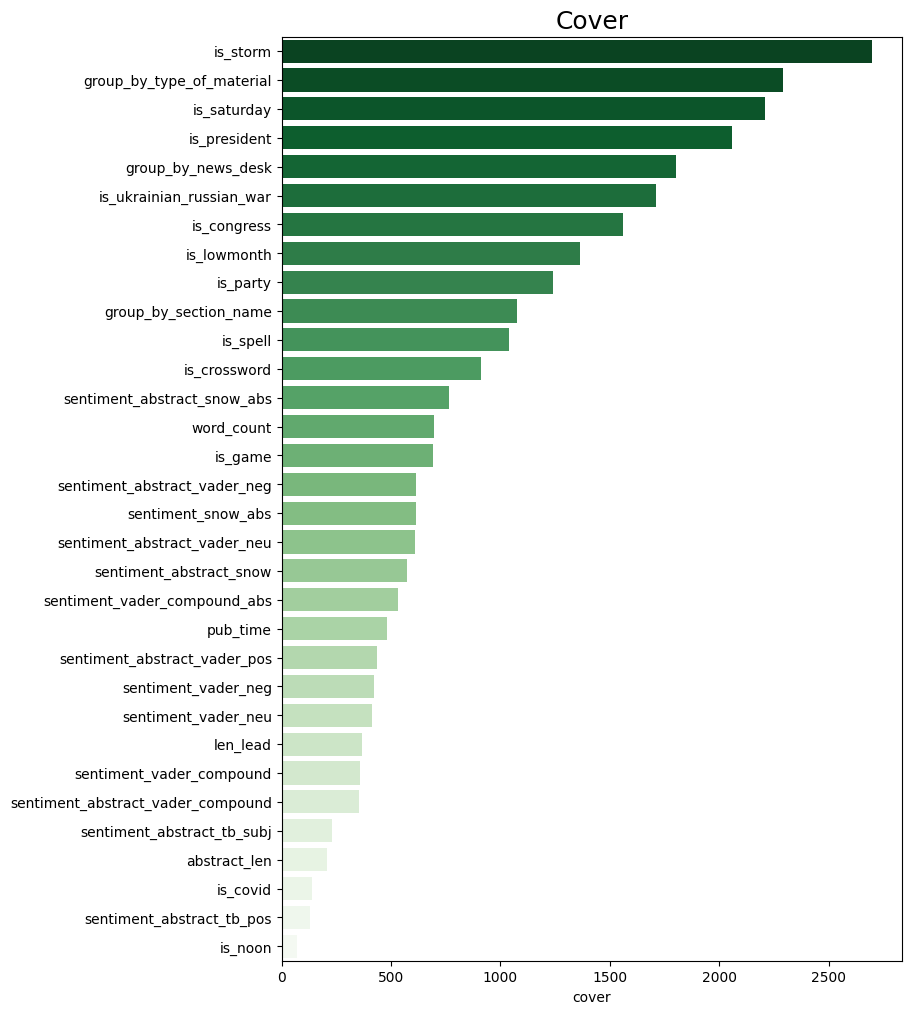

In [48]:
plt.figure(figsize=(8,12))
sns.barplot(data=cover_df, y='feature', x='cover', orient='h', palette='Greens_r')
plt.ylabel('');
plt.title('Cover', fontsize=18);

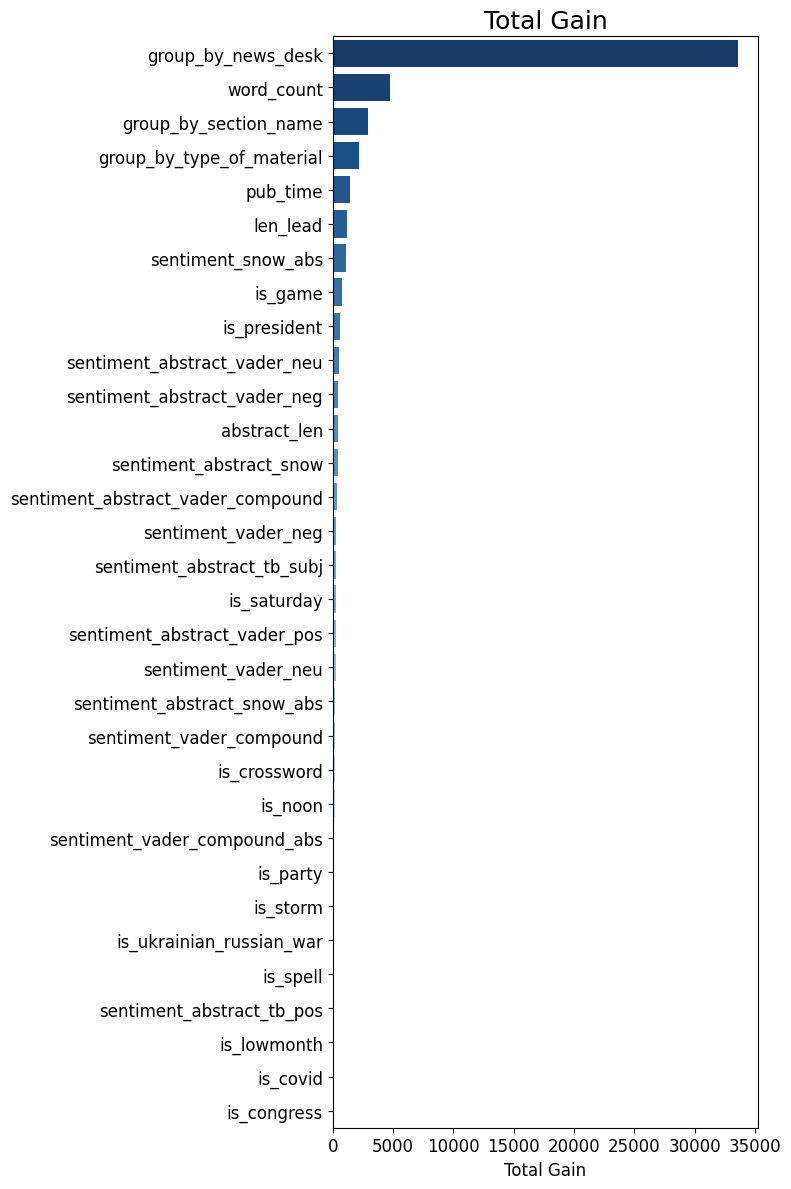

In [49]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_gain, y='feature', x='total gain', orient='h', palette='Blues_r')
plt.ylabel('');
plt.xlabel('Total Gain', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Gain', fontsize=18)
plt.tight_layout()
plt.savefig(fname='total_gain', dpi=180)

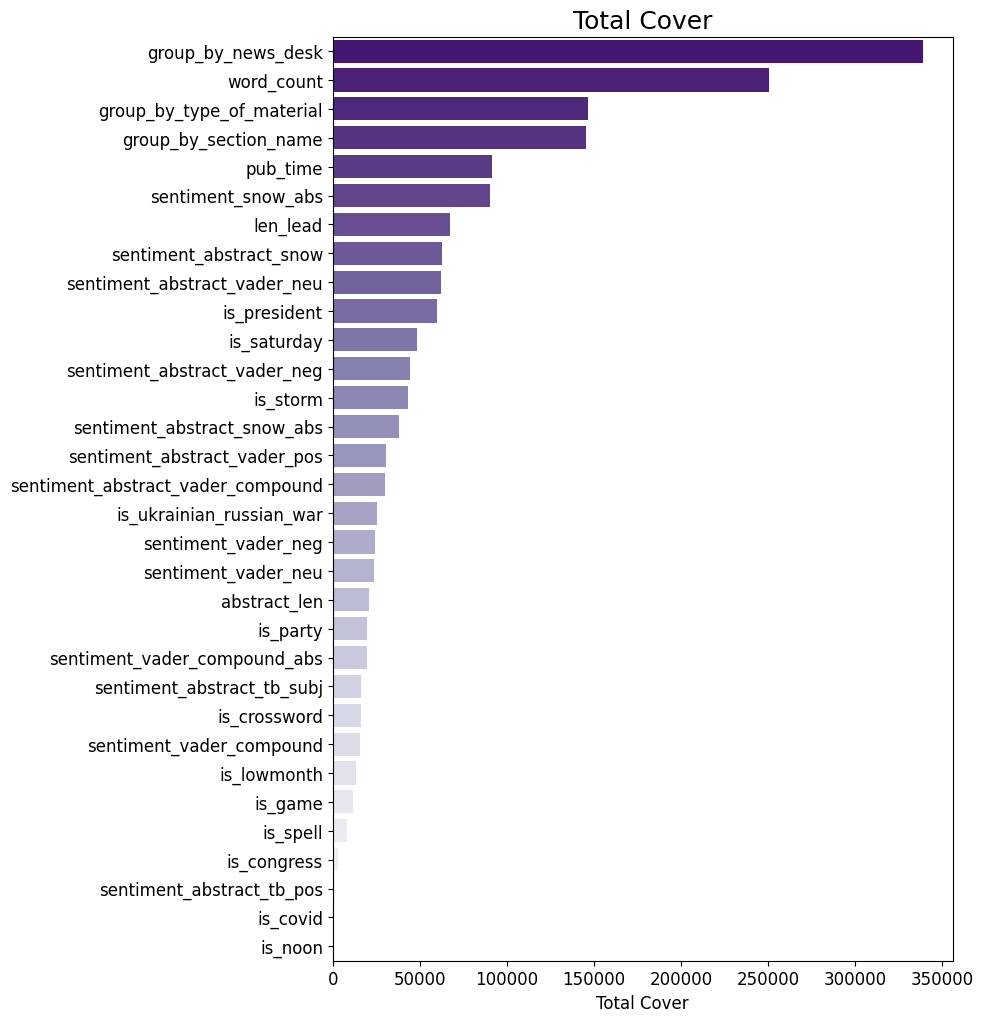

In [50]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_cover, y='feature', x='total cover', orient='h', palette='Purples_r')
plt.ylabel('');
plt.xlabel('Total Cover', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Cover', fontsize=18);

- Modified Version1.03</br>
The dataset has 30% is_popular data, as same as the unmodified dataset.

In [51]:
train = pd.read_pickle('./feature/feat_modified_v1_0.3.pkl')
part = 'xgb_mod_v1_03'
X = train.drop(columns=['is_popular', 'feature_subsection_name', 'group_by_subsection_name'])
y = train['is_popular']


data_list[part]['X_train'], data_list[part]['X_test'], data_list[part]['y_train'], data_list[part]['y_test'] = \
    train_test_split(X, y, test_size=0.3, random_state=42)

xgb_mod_v1_03 = run_model(part, 'xgb_mod_v1_03')
xgb_mod_v1_03_param = { 
              'xgb_mod_v1_03__learning_rate' : [0.1], 
              'xgb_mod_v1_03__max_depth' : [5],
              'xgb_mod_v1_03__n_estimators' : [200], 
              'xgb_mod_v1_03__reg_alpha' : [1.8], 
              'xgb_mod_v1_03__reg_lambda' : [0.1], 
              'xgb_mod_v1_03__gamma' : [3.0],
            }
xgb_gs_mod_v1_03 = run_model(part, 'xgb_mod_v1_03', mod_params=xgb_mod_v1_03_param, grid_search=True)
data_list[part]['test'] = pd.read_pickle('./feature/feat_test_modified_v1_0.3.pkl')
data_list[part]['test'] = data_list[part]['test']._get_numeric_data()

data_list[part]['final_actual'] = data_list[part]['test']['is_popular']
data_list[part]['test'] = data_list[part]['test'].drop(columns=['is_popular', 'feature_subsection_name', 'group_by_subsection_name'])

evaluate_model(part, xgb_gs_mod_v1_03)
xgb_gs_mod_v1_03.fit(X, y)
print(' ')
evaluate_model(part, xgb_gs_mod_v1_03)

### METRICS ###


{'model': 'xgb_mod_v1_03',
 'train_auc': 0.9808026647579081,
 'test_auc': 0.8373508475014212,
 'precision': 0.717736369910283,
 'specificity': 0.902246653919694,
 'recall': 0.5621621621621622,
 'f_score': 0.6304940891179145}

True Negatives: 3775
False Positives: 409
False Negatives: 810
True Positives: 1040
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[0.85941239]
[0.00341766]
[{'xgb_mod_v1_03__gamma': 3.0, 'xgb_mod_v1_03__learning_rate': 0.1, 'xgb_mod_v1_03__max_depth': 5, 'xgb_mod_v1_03__n_estimators': 200, 'xgb_mod_v1_03__reg_alpha': 1.8, 'xgb_mod_v1_03__reg_lambda': 0.1}]
### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=3.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb_mod_v1_03',
 'train_auc': 0.9091340931809021,
 'test_auc': 0.8475594930494548,
 'precision': 0.7424354243542436,
 'specificity': 0.9165869980879541,
 'recall': 0.5437837837837838,
 'f_score': 0.6277691107644306}

True Negatives: 3835
False Positives: 349
False Negatives: 844
True Positives: 1006
Accuracy: 0.807
Precision: 0.722
Recall: 0.562
ROC-AUC: 0.844
 
Accuracy: 0.808
Precision: 0.725
Recall: 0.562
ROC-AUC: 0.847


In [52]:
scores_dict = xgb_gs_mod_v1_03.steps[1][1]._Booster.get_score(importance_type='gain')
total_cover = pd.DataFrame(xgb_gs_mod_v1_03.steps[1][1]._Booster.get_score(importance_type='total_cover'), index=[0]) \
            .T.reset_index()
total_cover.columns = ['feature', 'total cover']
total_cover = total_cover.sort_values(by='total cover', ascending=False)
total_gain = pd.DataFrame(xgb_gs_mod_v1_03.steps[1][1]._Booster.get_score(importance_type='total_gain'), index=[0]) \
            .T.reset_index()
total_gain.columns = ['feature', 'total gain']
total_gain = total_gain.sort_values(by='total gain', ascending=False)
gain_df = pd.DataFrame(xgb_gs_mod_v1_03.steps[1][1]._Booster.get_score(importance_type='gain'), index=[0]) \
            .T.reset_index()
gain_df.columns = ['feature', 'gain']
gain_df = gain_df.sort_values(by='gain', ascending=False)
weight_df = pd.DataFrame(xgb_gs_mod_v1_03.steps[1][1]._Booster.get_score(importance_type='weight'), index=[0]) \
            .T.reset_index()
weight_df.columns = ['feature', 'weight']
weight_df = weight_df.sort_values(by='weight', ascending=False)
cover_df = pd.DataFrame(xgb_gs_mod_v1_03.steps[1][1]._Booster.get_score(importance_type='cover'), index=[0]) \
            .T.reset_index()
cover_df.columns = ['feature', 'cover']
cover_df = cover_df.sort_values(by='cover', ascending=False)

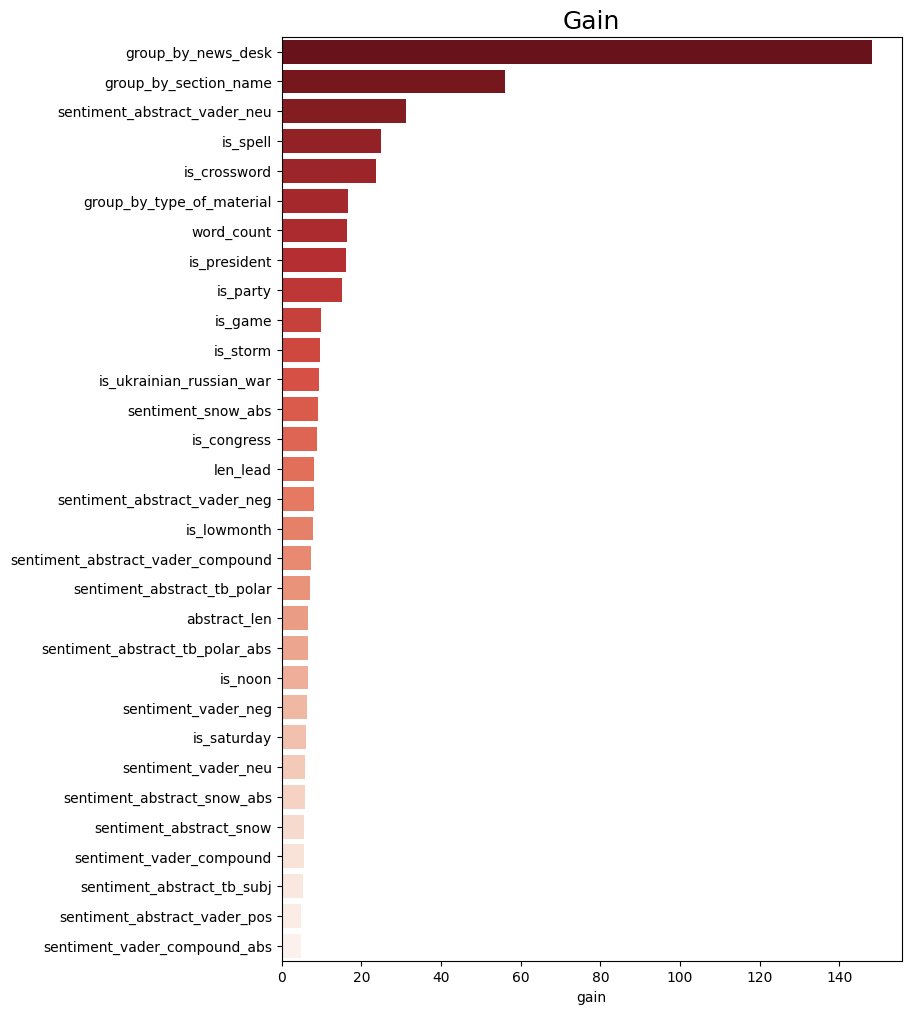

In [53]:
plt.figure(figsize=(8,12))
sns.barplot(data=gain_df, y='feature', x='gain', orient='h', palette='Reds_r')
plt.ylabel('');
plt.title('Gain', fontsize=18);

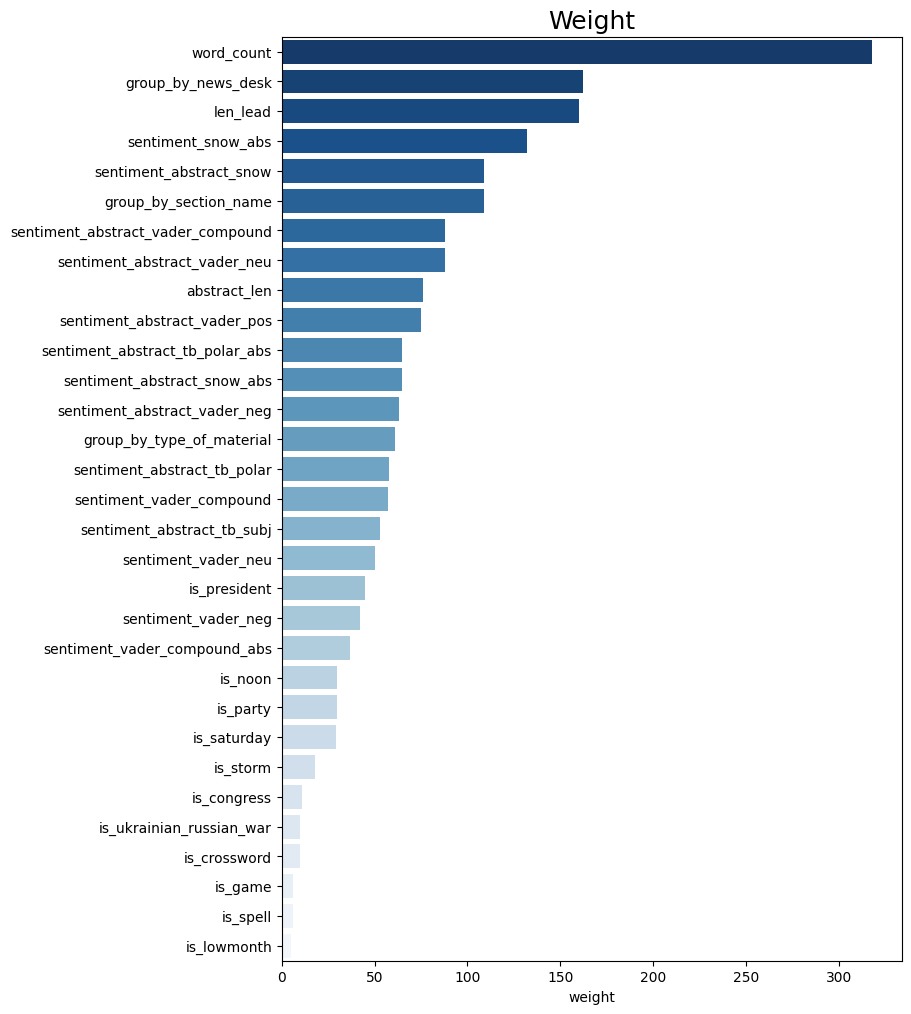

In [54]:
plt.figure(figsize=(8,12))
sns.barplot(data=weight_df, y='feature', x='weight', orient='h', palette='Blues_r')
plt.ylabel('');
plt.title('Weight', fontsize=18);

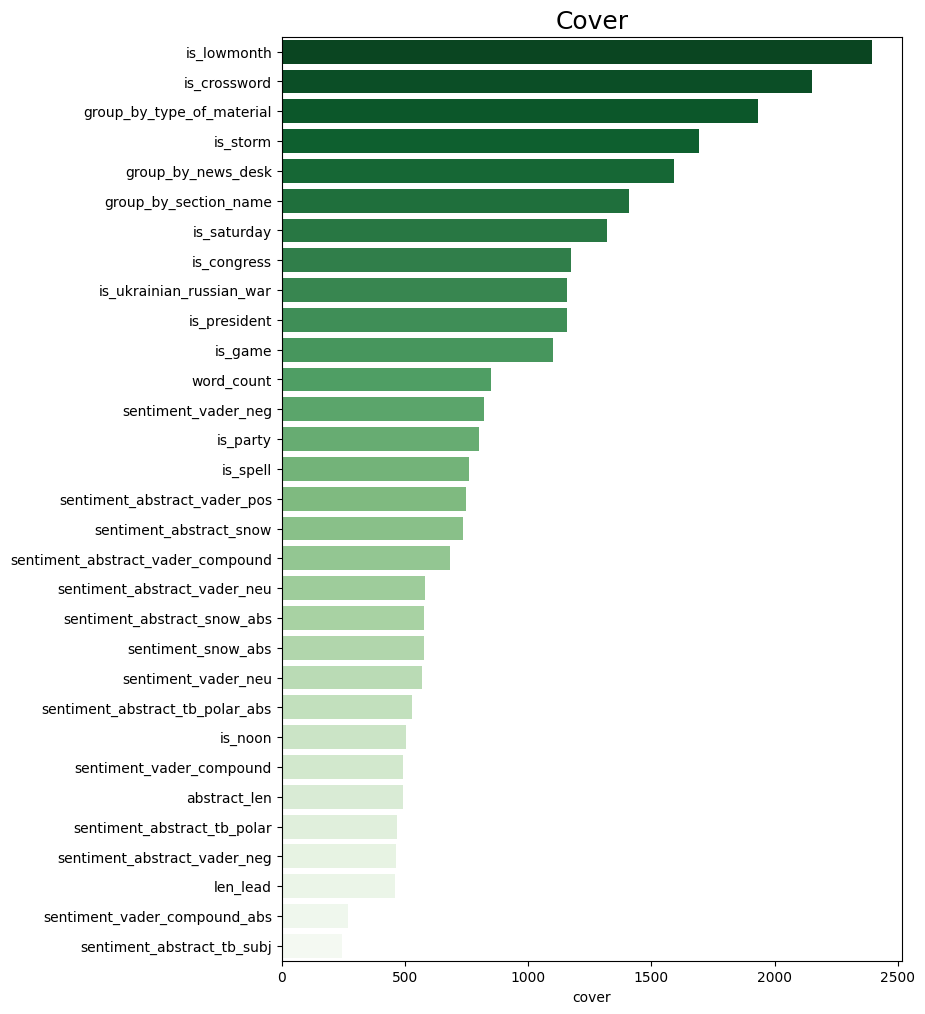

In [55]:
plt.figure(figsize=(8,12))
sns.barplot(data=cover_df, y='feature', x='cover', orient='h', palette='Greens_r')
plt.ylabel('');
plt.title('Cover', fontsize=18);

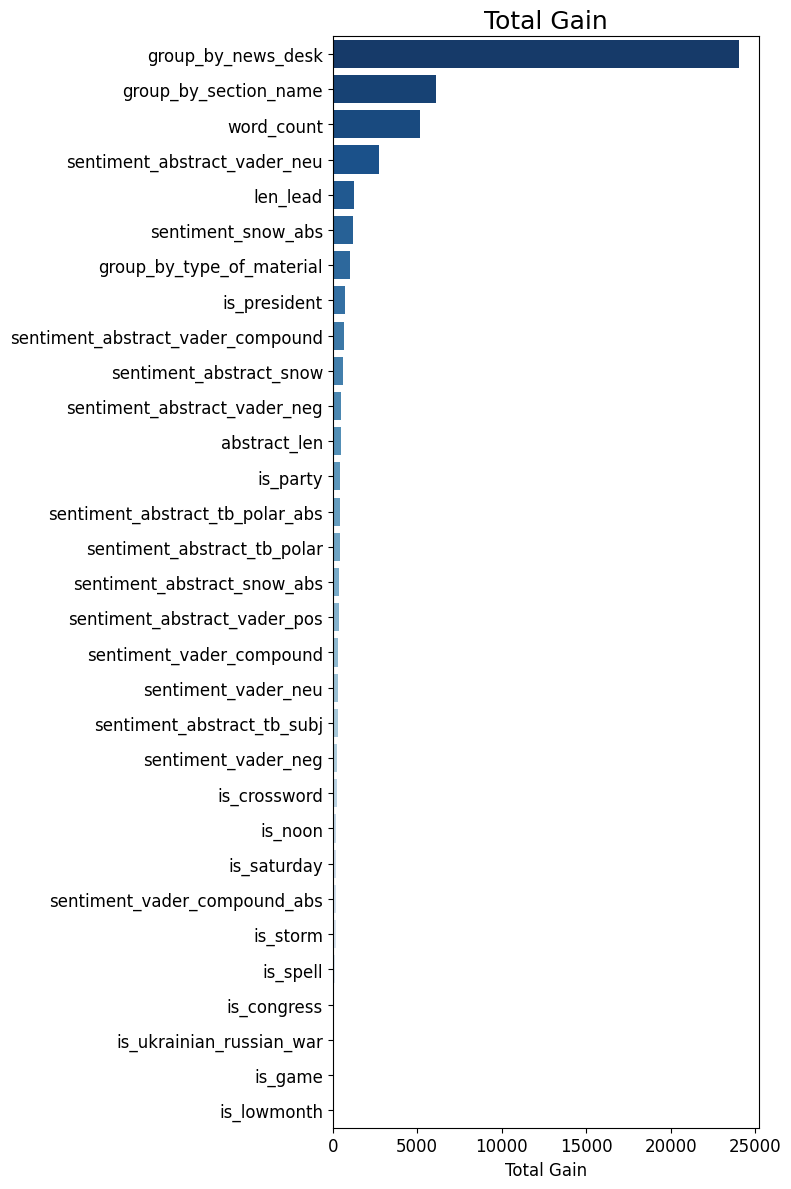

In [56]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_gain, y='feature', x='total gain', orient='h', palette='Blues_r')
plt.ylabel('');
plt.xlabel('Total Gain', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Gain', fontsize=18)
plt.tight_layout()
plt.savefig(fname='total_gain', dpi=180)

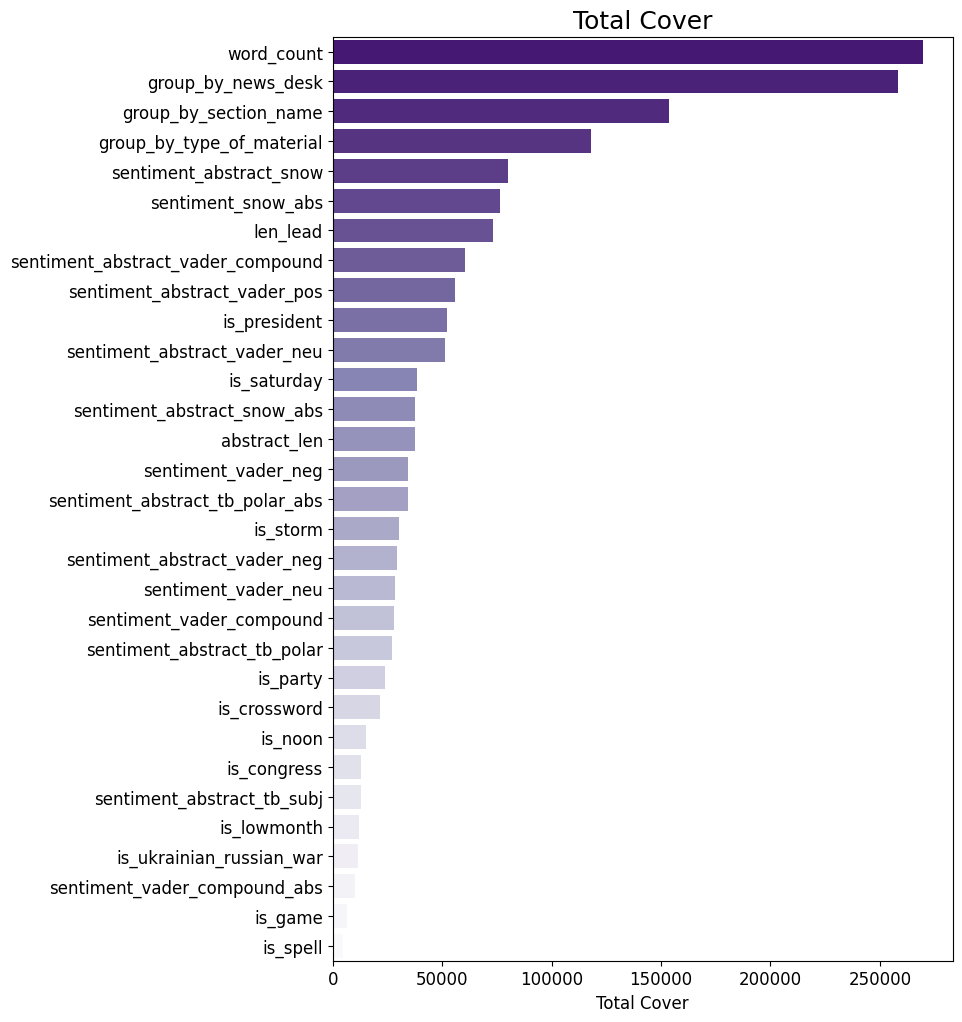

In [57]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_cover, y='feature', x='total cover', orient='h', palette='Purples_r')
plt.ylabel('');
plt.xlabel('Total Cover', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Cover', fontsize=18);

- Modified Version2

In [58]:
train = pd.read_pickle('./feature/feat_modified_v2.pkl')
part = 'xgb_mod_v2'
X = train.drop(columns=['is_popular'])
y = train['is_popular']


data_list[part]['X_train'], data_list[part]['X_test'], data_list[part]['y_train'], data_list[part]['y_test'] = \
    train_test_split(X, y, test_size=0.3, random_state=42)

xgb_mod_v2 = run_model(part, 'xgb_mod_v2')
xgb_mod_v2_param = { 
              'xgb_mod_v2__learning_rate' : [0.1], 
              'xgb_mod_v2__max_depth' : [5],
              'xgb_mod_v2__n_estimators' : [300], 
              'xgb_mod_v2__reg_alpha' : [1.0], 
              'xgb_mod_v2__reg_lambda' : [3.0], 
              'xgb_mod_v2__gamma' : [2.0],
            }
xgb_gs_mod_v2 = run_model(part, 'xgb_mod_v2', mod_params=xgb_mod_v2_param, grid_search=True)
data_list[part]['test'] = pd.read_pickle('./feature/feat_test_modified_v2.pkl')
data_list[part]['test'] = data_list[part]['test']._get_numeric_data()

data_list[part]['final_actual'] = data_list[part]['test']['is_popular']
data_list[part]['test'] = data_list[part]['test'].drop(columns=['is_popular'])

evaluate_model(part, xgb_gs_mod_v2)
xgb_gs_mod_v2.fit(X, y)
print(' ')
evaluate_model(part, xgb_gs_mod_v2)

### METRICS ###


{'model': 'xgb_mod_v2',
 'train_auc': 0.9745069257540302,
 'test_auc': 0.833544544487334,
 'precision': 0.7451388888888889,
 'specificity': 0.7616883116883116,
 'recall': 0.7264725795531483,
 'f_score': 0.7356873500171409}

True Negatives: 2346
False Positives: 734
False Negatives: 808
True Positives: 2146
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[0.84423438]
[0.00134455]
[{'xgb_mod_v2__gamma': 2.0, 'xgb_mod_v2__learning_rate': 0.1, 'xgb_mod_v2__max_depth': 5, 'xgb_mod_v2__n_estimators': 300, 'xgb_mod_v2__reg_alpha': 1.0, 'xgb_mod_v2__reg_lambda': 3.0}]
### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb_mod_v2',
 'train_auc': 0.9291171290587124,
 'test_auc': 0.8419028458001037,
 'precision': 0.7605683836589698,
 'specificity': 0.7811688311688312,
 'recall': 0.7247799593771158,
 'f_score': 0.7422430230542556}

True Negatives: 2406
False Positives: 674
False Negatives: 813
True Positives: 2141
Accuracy: 0.757
Precision: 0.769
Recall: 0.734
ROC-AUC: 0.846
 
Accuracy: 0.758
Precision: 0.771
Recall: 0.735
ROC-AUC: 0.849


In [59]:
scores_dict = xgb_gs_mod_v2.steps[1][1]._Booster.get_score(importance_type='gain')
total_cover = pd.DataFrame(xgb_gs_mod_v2.steps[1][1]._Booster.get_score(importance_type='total_cover'), index=[0]) \
            .T.reset_index()
total_cover.columns = ['feature', 'total cover']
total_cover = total_cover.sort_values(by='total cover', ascending=False)
total_gain = pd.DataFrame(xgb_gs_mod_v2.steps[1][1]._Booster.get_score(importance_type='total_gain'), index=[0]) \
            .T.reset_index()
total_gain.columns = ['feature', 'total gain']
total_gain = total_gain.sort_values(by='total gain', ascending=False)
gain_df = pd.DataFrame(xgb_gs_mod_v2.steps[1][1]._Booster.get_score(importance_type='gain'), index=[0]) \
            .T.reset_index()
gain_df.columns = ['feature', 'gain']
gain_df = gain_df.sort_values(by='gain', ascending=False)
weight_df = pd.DataFrame(xgb_gs_mod_v2.steps[1][1]._Booster.get_score(importance_type='weight'), index=[0]) \
            .T.reset_index()
weight_df.columns = ['feature', 'weight']
weight_df = weight_df.sort_values(by='weight', ascending=False)
cover_df = pd.DataFrame(xgb_gs_mod_v2.steps[1][1]._Booster.get_score(importance_type='cover'), index=[0]) \
            .T.reset_index()
cover_df.columns = ['feature', 'cover']
cover_df = cover_df.sort_values(by='cover', ascending=False)

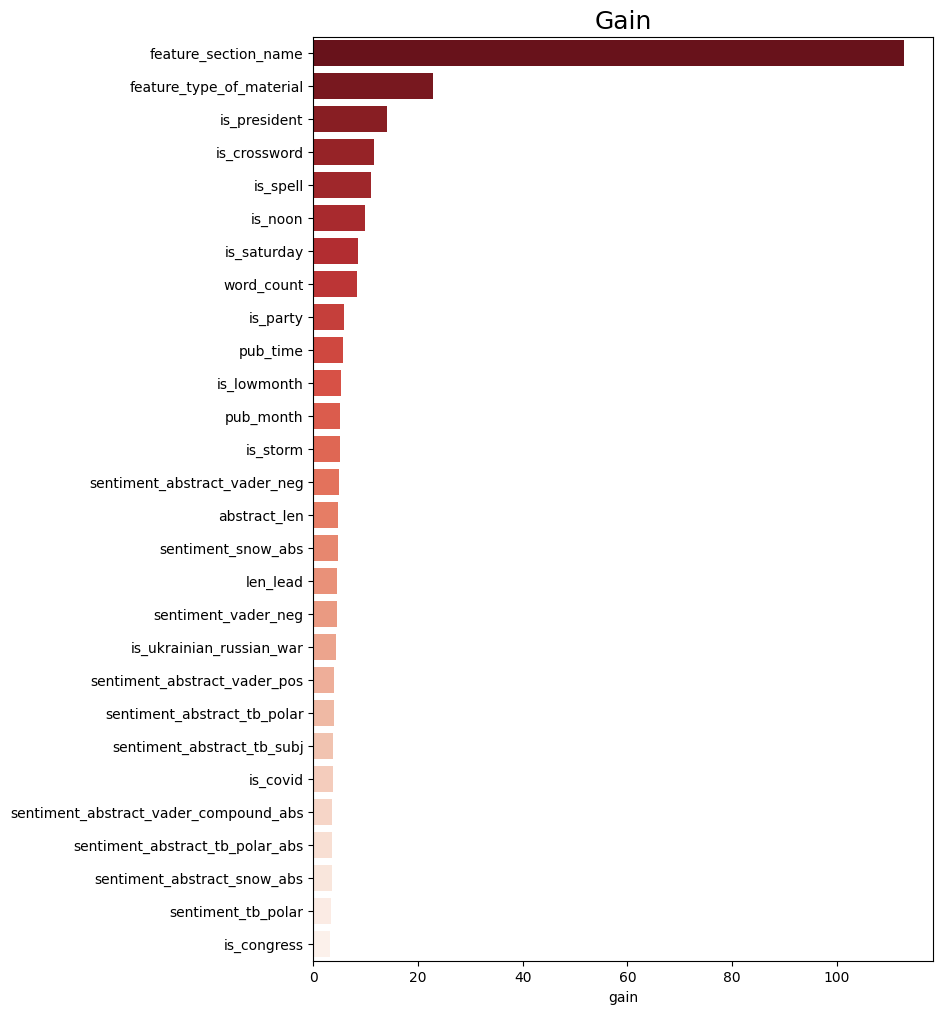

In [60]:
plt.figure(figsize=(8,12))
sns.barplot(data=gain_df, y='feature', x='gain', orient='h', palette='Reds_r')
plt.ylabel('');
plt.title('Gain', fontsize=18);

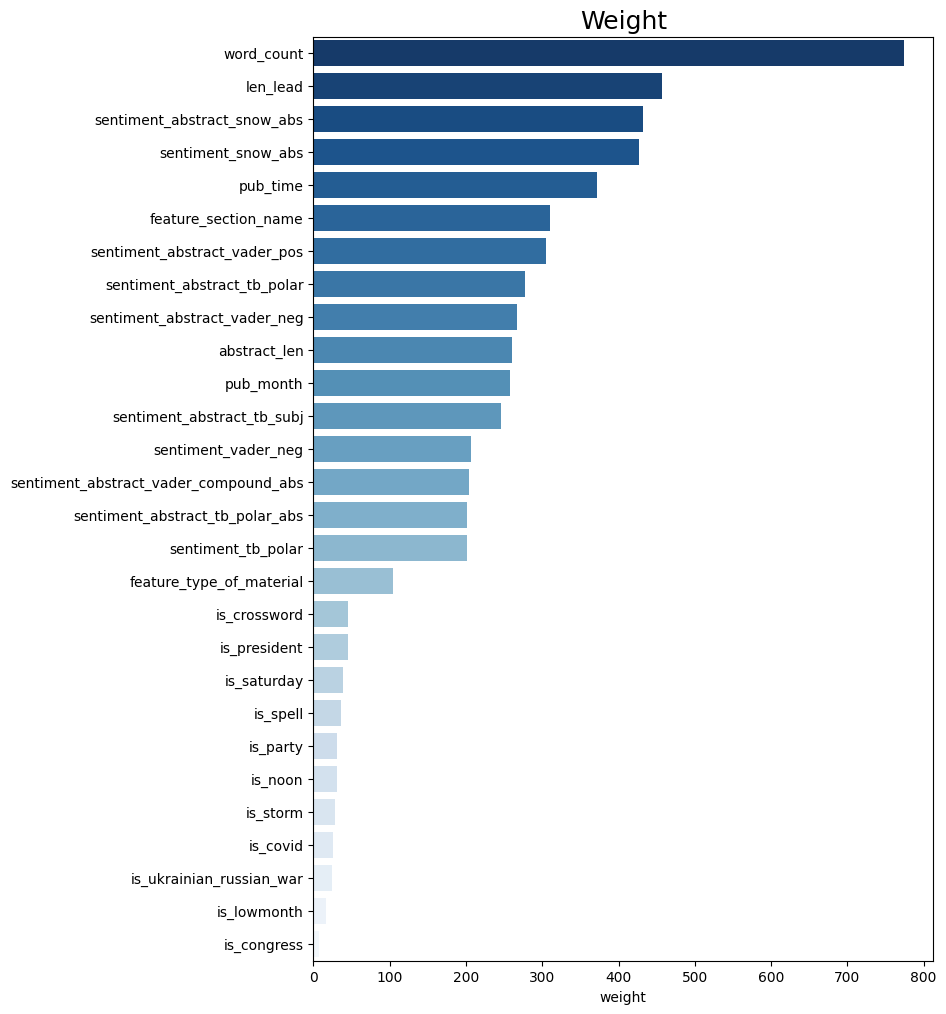

In [61]:
plt.figure(figsize=(8,12))
sns.barplot(data=weight_df, y='feature', x='weight', orient='h', palette='Blues_r')
plt.ylabel('');
plt.title('Weight', fontsize=18);

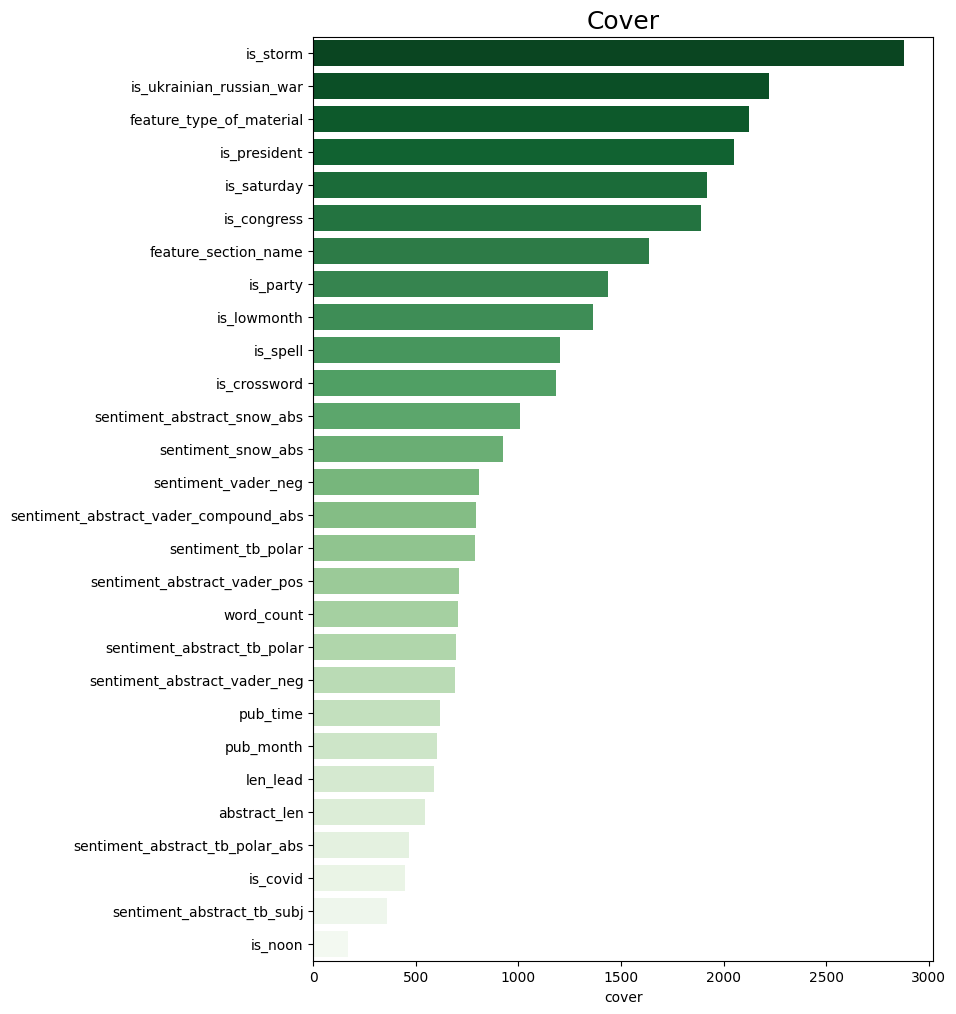

In [62]:
plt.figure(figsize=(8,12))
sns.barplot(data=cover_df, y='feature', x='cover', orient='h', palette='Greens_r')
plt.ylabel('');
plt.title('Cover', fontsize=18);

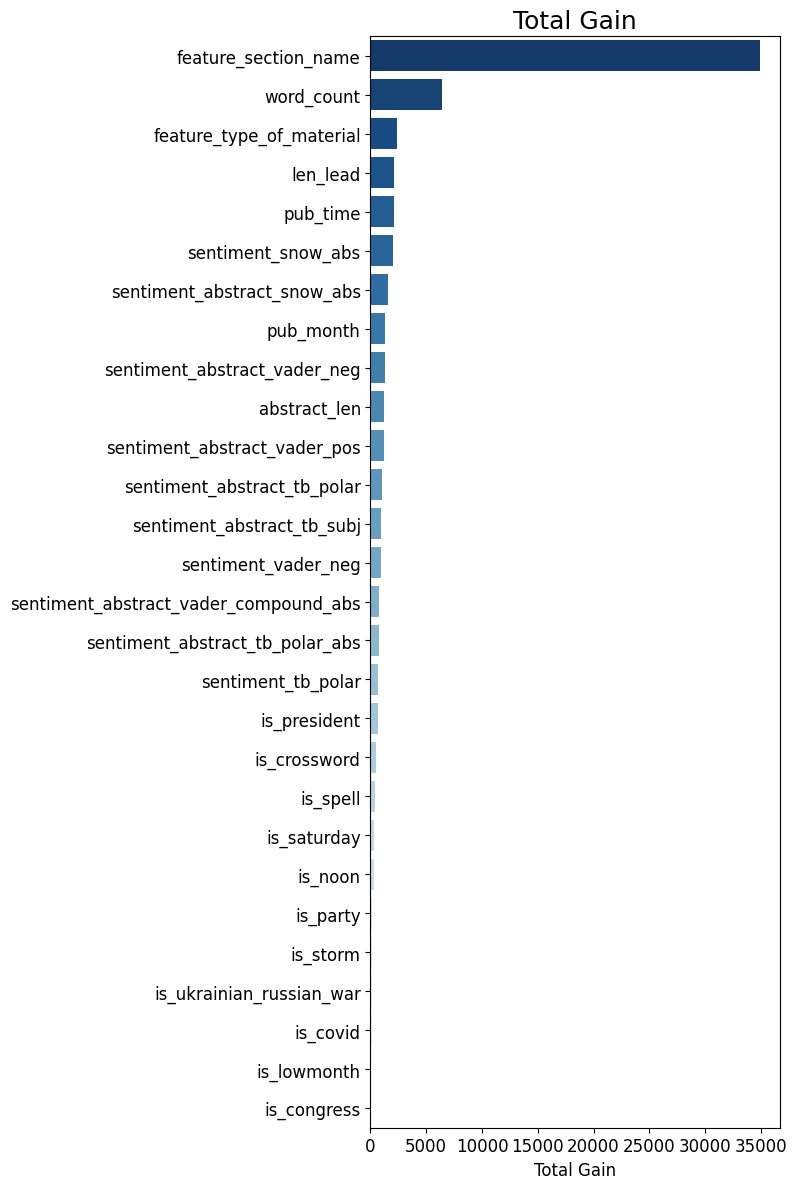

In [63]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_gain, y='feature', x='total gain', orient='h', palette='Blues_r')
plt.ylabel('');
plt.xlabel('Total Gain', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Gain', fontsize=18)
plt.tight_layout()
plt.savefig(fname='total_gain', dpi=180)

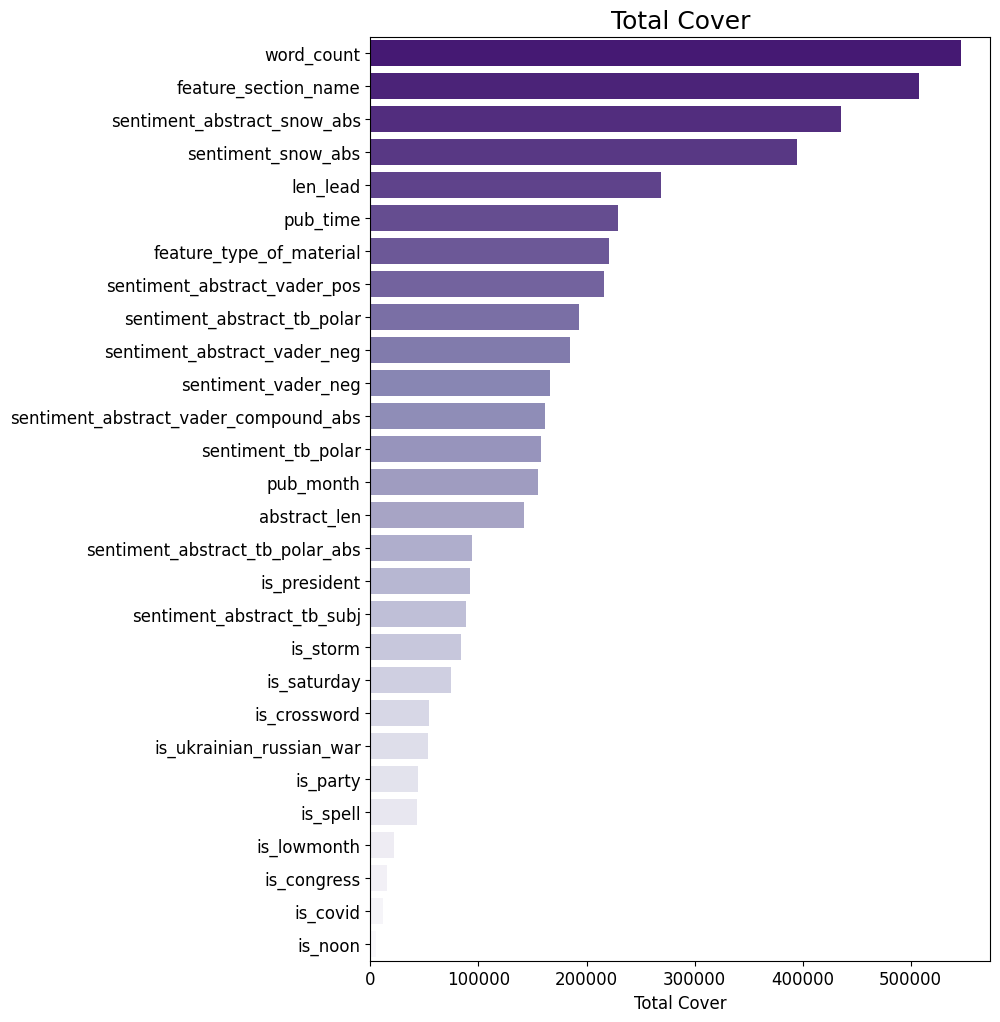

In [64]:
plt.figure(figsize=(8,12))
sns.barplot(data=total_cover, y='feature', x='total cover', orient='h', palette='Purples_r')
plt.ylabel('');
plt.xlabel('Total Cover', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Total Cover', fontsize=18);

# Decision Tree

In [73]:
part = 'dt'
data_list[part] = {}
train = pd.read_pickle('./feature/feat_modified_v1.pkl')
X = train.drop(columns=['is_popular', 'group_by_subsection_name', 'feature_subsection_name'])
y = train['is_popular']

data_list[part]['X_train'], data_list[part]['X_test'], data_list[part]['y_train'], data_list[part]['y_test'] = \
    train_test_split(X, y, test_size=0.3, random_state=42)

dt = run_model(part, 'dt')
dt_param = {'dt__min_samples_leaf' : [0.01, 0.1, 1, 2, 3],
            'dt__max_leaf_nodes' : [10, 30, 50, 70, 100]}

dt_gs = run_model(part, 'dt', mod_params=dt_param, grid_search=True)
data_list[part]['test'] = pd.read_pickle('./feature/feat_test_modified_v1.pkl')
data_list[part]['test'] = data_list[part]['test']._get_numeric_data()

data_list[part]['final_actual'] = data_list[part]['test']['is_popular']
data_list[part]['test'] = data_list[part]['test'].drop(columns=['is_popular', 'feature_subsection_name', 'group_by_subsection_name'])

evaluate_model(part, dt_gs)
dt_gs.fit(X, y)
print(' ')
evaluate_model(part, dt_gs)

### METRICS ###


{'model': 'dt',
 'train_auc': 0.9999997073530316,
 'test_auc': 0.6897124229253008,
 'precision': 0.6916285153695225,
 'specificity': 0.6846153846153846,
 'recall': 0.6948094612352168,
 'f_score': 0.6932153392330384}

True Negatives: 2047
False Positives: 943
False Negatives: 929
True Positives: 2115
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[0.82081126 0.80973825 0.81974102 0.81974102 0.81974102 0.82959833
 0.80973825 0.83469172 0.83469172 0.83469172 0.82918443 0.80973825
 0.82955816 0.82955816 0.82955816 0.8294406  0.80973825 0.82517614
 0.82517614 0.82517614 0.82948874 0.80973825 0.82102206 0.82102206
 0.82138002]
[0.00139419 0.00138919 0.00221697 0.00221697 0.00221697 0.00193455
 0.00138919 0.00523436 0.00523436 0.00523436 0.00326691 0.00138919
 0.00609638 0.00609638 0.00609638 0.00287916 0.00138919 0.00833997
 0.00833997 0.00833997 0.00307284 0.00138919 0.00636608 0.00636608
 0.00743203]
[{'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 0.01}, {'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 0.1}, {'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 1}, {'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 2}, {'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 3}, {'dt__max_le

DecisionTreeClassifier(max_leaf_nodes=30, random_state=42)

### METRICS ###


{'model': 'dt',
 'train_auc': 0.8474032344634633,
 'test_auc': 0.8321298766365326,
 'precision': 0.7717506164142304,
 'specificity': 0.7832775919732441,
 'recall': 0.7197766097240473,
 'f_score': 0.7448580656127826}

True Negatives: 2342
False Positives: 648
False Negatives: 853
True Positives: 2191
Accuracy: 0.756
Precision: 0.765
Recall: 0.737
ROC-AUC: 0.835
 
Accuracy: 0.760
Precision: 0.797
Recall: 0.697
ROC-AUC: 0.837


# Result Analysis

In [68]:
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,rf_v1,1.000000,0.886143,0.757903,0.908854,0.624958,0.685040
1,xgb_v1,0.944539,0.881929,0.726846,0.888351,0.650690,0.686663
2,rf_v2,1.000000,0.869377,0.756781,0.915030,0.573146,0.652285
3,xgb_v2,0.938948,0.867005,0.725321,0.894538,0.603707,0.658950
4,rf_mod_v1,0.999988,0.846443,0.779908,0.792642,0.721748,0.749701
5,rf_mod_v2,1.000000,0.842965,0.776059,0.802597,0.713270,0.743341
6,rf_mod_v1_03,0.999946,0.841942,0.747543,0.920172,0.534595,0.623385
7,xgb_mod_v1_03,0.980803,0.837351,0.717736,0.902247,0.562162,0.630494
8,xgb_mod_v1,0.975767,0.837336,0.766749,0.777592,0.718134,0.741645
9,xgb_mod_v2,0.974507,0.833545,0.745139,0.761688,0.726473,0.735687


In [69]:
gs_df = pd.DataFrame(gs_list)
gs_df.sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,rf_v1,0.994526,0.889330,0.766764,0.914536,0.615372,0.682777
1,xgb_v1,0.922508,0.884741,0.734814,0.892728,0.651026,0.690387
2,rf_v2,0.999212,0.871493,0.764600,0.919575,0.566299,0.650676
3,xgb_v2,0.911770,0.870054,0.737067,0.900547,0.604375,0.664159
4,dt,0.876887,0.866314,0.744550,0.907318,0.591658,0.659357
5,rf_mod_v1_03,0.966664,0.847779,0.762125,0.926147,0.535135,0.628771
6,rf_mod_v1,0.938962,0.847725,0.793924,0.811706,0.712549,0.751039
7,xgb_mod_v1_03,0.909134,0.847559,0.742435,0.916587,0.543784,0.627769
8,rf_mod_v2,0.982929,0.846519,0.780909,0.810714,0.703453,0.740160
9,xgb_mod_v1,0.888466,0.844305,0.787691,0.805017,0.710578,0.747150


In [78]:
gs_dict = {
    rf_gs_v1: ['RandomForest Unmodified V1', 'rf_v1'],
    rf_gs_v2: ['RandomForest Unmodified V2', 'rf_v2'],
    rf_gs_mod_v1: ['RandomForest Modified V1', 'rf_mod_v1'],
    rf_gs_mod_v1_03: ['RandomForest Modified V1-0.3', 'rf_mod_v1_03'],
    rf_gs_mod_v2: ['RandomForest Modified V2', 'rf_mod_v2'],
    xgb_gs_v1: ['XGBoostClassfier Unmodified V1', 'xgb_v1'],
    xgb_gs_v2: ['XGBoostClassfier Unmodified V2', 'xgb_v2'],
    xgb_gs_mod_v1: ['XGBoostClassfier Modified V1', 'xgb_mod_v1'],
    xgb_gs_mod_v1_03: ['XGBoostClassfier Modified V1-0.3', 'xgb_mod_v1_03'],
    xgb_gs_mod_v2: ['XGBoostClassfier Modified V2', 'xgb_mod_v2'],
    dt_gs: ['Baseline DecisionTree', 'dt']
}

In [71]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = sklearn.metrics.RocCurveDisplay.from_estimator(m, data_list[model_dict[m][1]]['test'], data_list[model_dict[m][1]]['final_actual'], ax=ax, name=model_dict[m][0])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('gray')
                axes[a].line_.set_alpha(0.25)
                
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

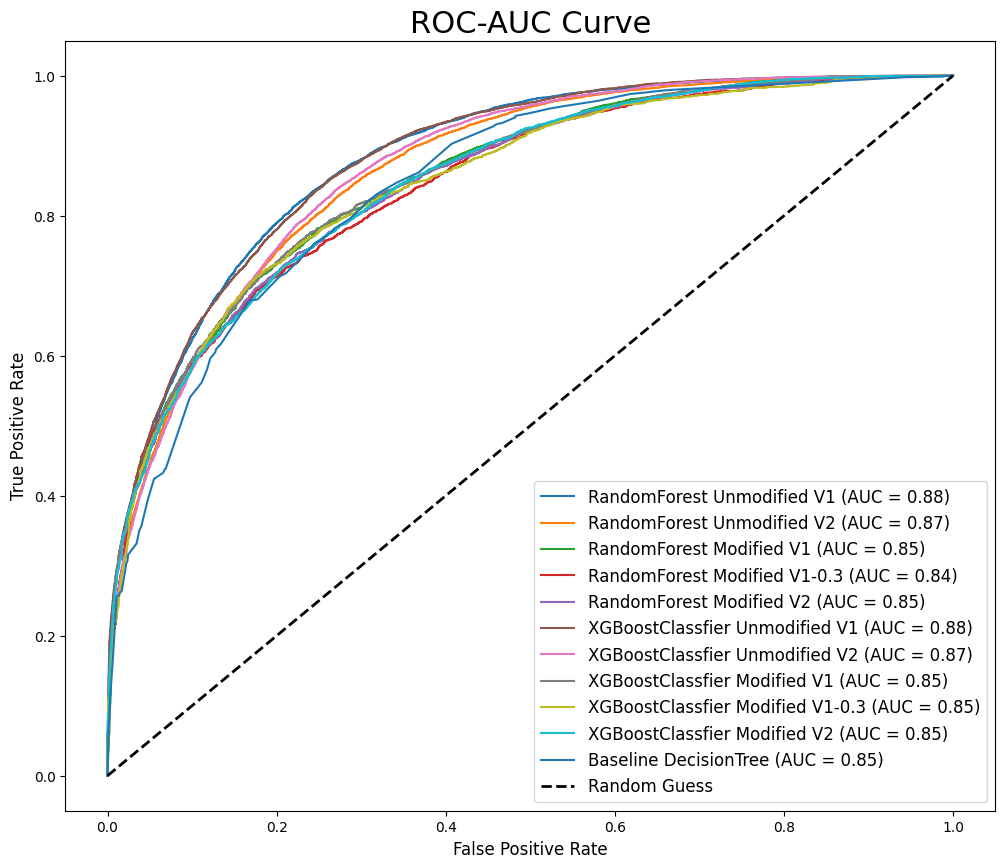

In [72]:
roc_curve_plotter(gs_dict, False)

In [ ]:
part = 'test'
model_name = 'rf_mod_v1'
model = rf_gs_mod_v1
data_list[part] = data_list[model_name]
data_list[part]['test'] = pd.read_pickle('./feature/feat_test_v1.pkl')


data_list[part]['test'] = data_list[part]['test']._get_numeric_data()

data_list[part]['final_actual'] = data_list[part]['test']['is_popular']
data_list[part]['test'] = data_list[part]['test'].drop(columns=['is_popular', 'feature_subsection_name', 'group_by_subsection_name'])
data_list[part]['test']['is_saturday'] = [0 for i in range(len(data_list[part]['test']))]
data_list[part]['sentiment_abstract_vader_compound_abs'] = [0 for i in range(len(data_list[part]['test']))]
data_list[part]['sentiment_abstract_vader_neh'] = [0 for i in range(len(data_list[part]['test']))]


evaluate_model(part, model)

In [76]:
target = [rf_gs_v1, rf_gs_v2, rf_gs_mod_v1, rf_gs_mod_v2, rf_gs_mod_v1_03, dt_gs]

In [88]:
def analyze(parts):
    model_dict = {}
    col = ['index']
    for p in parts:
        model_dict[p] = gs_dict[p]
        col.append(gs_dict[p][1])
    col.append('test')
    roc_curve_plotter(model_dict, False)
    datas = [['accuracy'], ['precision'], ['recall'], ['f_score'], ['roc-auc'], ['TPR'], ['FPR'], ['Positive Ratio']]
    for data in datas:
        index = data[0]
        if index == 'Positive Ratio':
            for mod in col[1:]:
                r = (data_list[mod]['tp'] + data_list[mod]['fn'])  \
                    / (data_list[mod]['tn'] + data_list[mod]['fp'] + data_list[mod]['tp'] + data_list[mod]['fn'])
                data.append(r)
        elif index == 'TPR':
            for mod in col[1:]:
                r = data_list[mod]['tp'] / (data_list[mod]['tp'] + data_list[mod]['fn'])
                data.append(r)
        
        elif index == 'FPR':
            for mod in col[1:]:
                r = data_list[mod]['fp'] / (data_list[mod]['tn'] + data_list[mod]['fp'])
                data.append(r)
        else:
            for mod in col[1:]:
                data.append(data_list[mod][index])
    df = pd.DataFrame(datas, columns=col)
    df.plot(x="index", y=col[1:], kind="bar",figsize=(10, 10))
    plt.show()


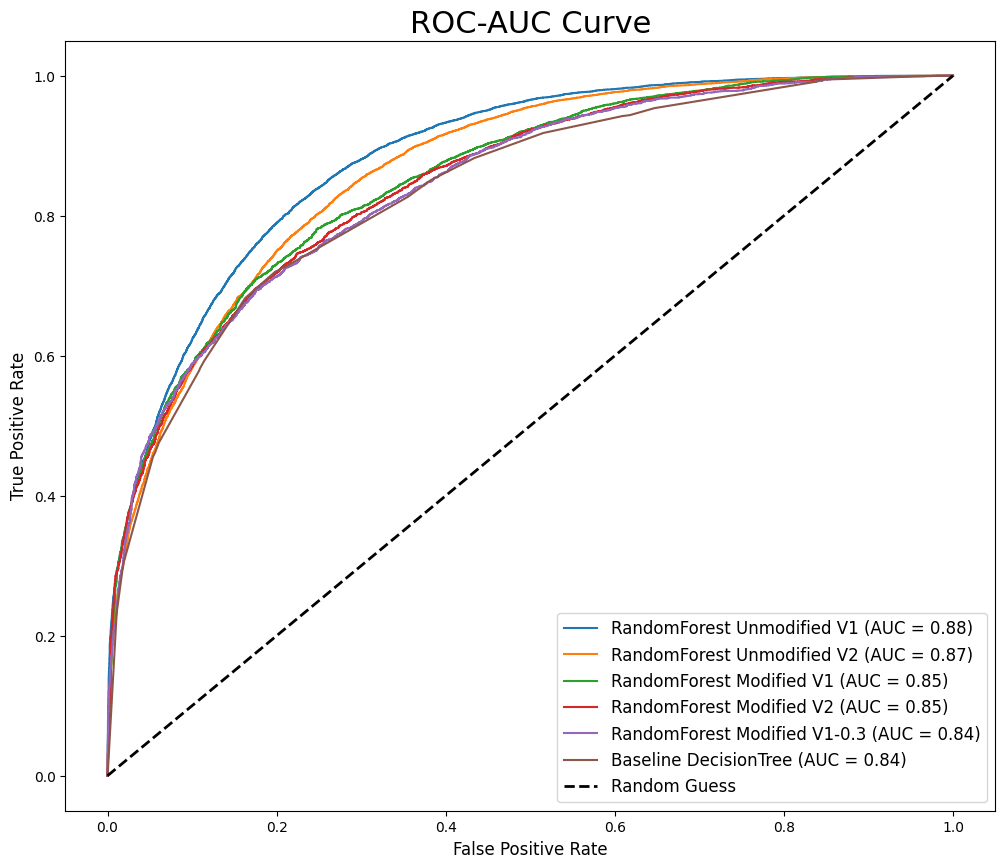

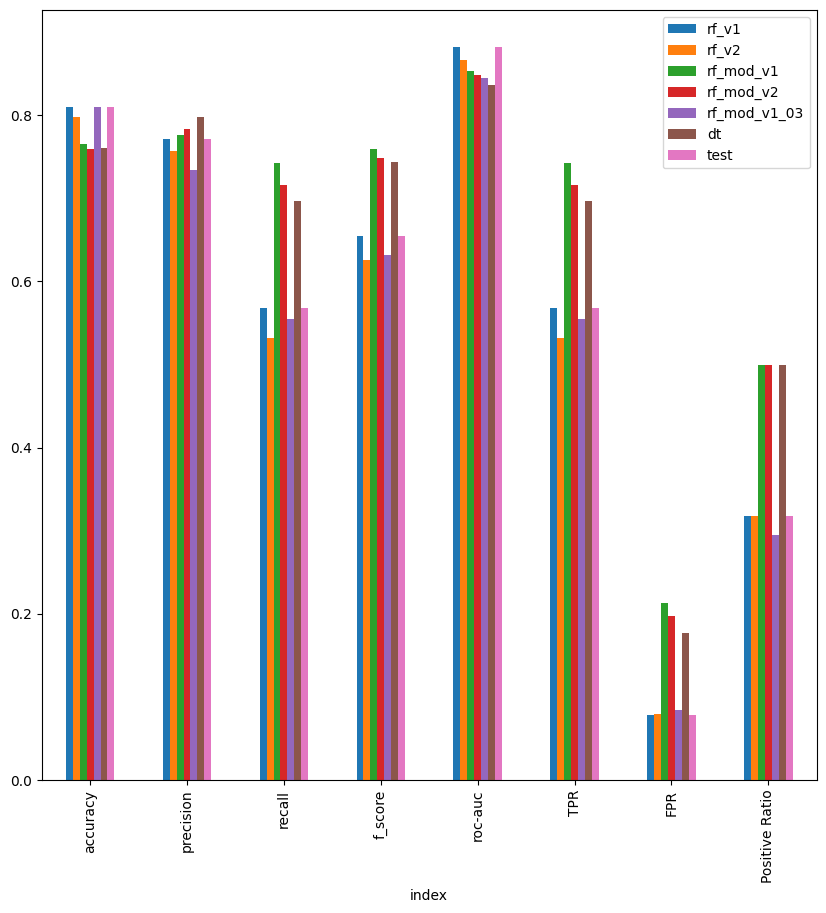

In [89]:
analyze(target)

因為Unmodified的0comment比較多，所以model能更好的區別0comment的特徵，提高non-popular的TP和